In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
from sklearn.model_selection import StratifiedGroupKFold
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
with open('../feat_selection/select_optuna_lgbm.json', 'r') as f:
    feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', [])
categorical_cols = feature_selection.get('categorical', [])

print("Numerical features:", len(numerical_cols))
print("Categorical features:", len(categorical_cols))

Numerical features: 296
Categorical features: 5


In [4]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 368
Categorical Columns: 5


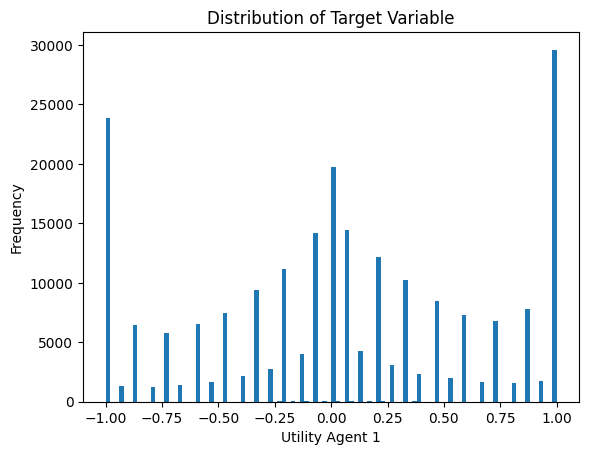

In [5]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

***
### train model


In [6]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        num_folds=5,
        cv_random_state=2112,
    ):
    # Define the number of folds for cross-validation
    group_col = "GameRulesetName"
    y_col = "utility_agent1_rank"
    gkf = StratifiedGroupKFold(n_splits=num_folds, random_state=cv_random_state, shuffle=True)
    split_list = gkf.split(df_train, groups=df_train[group_col], y=df_train[y_col])

    # Define the parameters
    params = {
        'objective': "regression",
        'extra_trees': True,
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'max_depth': 10,
        'learning_rate': 0.1,
        'reg_alpha': 1e-1,
        'reg_lambda': 1e-1,
        'feature_fraction': 0.8,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(index=df_train.index, columns=[f'{target}_true', f'{target}_pred'])
    oof_scores = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=2000,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=50),
            ]
        )
        lgb.plot_importance(model, figsize=(8, 20), importance_type='gain', max_num_features=100)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])
        y_pred = np.clip(y_pred, -1, 1)
        
        # Compute RMSE on scaled values
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores

/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1


[50]	valid_0's rmse: 0.476081


[100]	valid_0's rmse: 0.461796


[150]	valid_0's rmse: 0.456356


[200]	valid_0's rmse: 0.453659


[250]	valid_0's rmse: 0.451943


[300]	valid_0's rmse: 0.451965


[350]	valid_0's rmse: 0.450661


[400]	valid_0's rmse: 0.450071


[450]	valid_0's rmse: 0.449049


[500]	valid_0's rmse: 0.448552


[550]	valid_0's rmse: 0.448323


[600]	valid_0's rmse: 0.447806


[650]	valid_0's rmse: 0.447546


[700]	valid_0's rmse: 0.447426


[750]	valid_0's rmse: 0.447525


[800]	valid_0's rmse: 0.447582


[850]	valid_0's rmse: 0.447332


[900]	valid_0's rmse: 0.447207


[950]	valid_0's rmse: 0.446821


[1000]	valid_0's rmse: 0.446773


[1050]	valid_0's rmse: 0.44665


[1100]	valid_0's rmse: 0.446471


[1150]	valid_0's rmse: 0.446523


[1200]	valid_0's rmse: 0.446525


[1250]	valid_0's rmse: 0.446381


[1300]	valid_0's rmse: 0.446181


[1350]	valid_0's rmse: 0.446061


[1400]	valid_0's rmse: 0.446054


[1450]	valid_0's rmse: 0.446392


[1500]	valid_0's rmse: 0.446385


[1550]	valid_0's rmse: 0.446205


[1600]	valid_0's rmse: 0.446279


[1650]	valid_0's rmse: 0.446116


[1700]	valid_0's rmse: 0.446197


[1750]	valid_0's rmse: 0.446225


[1800]	valid_0's rmse: 0.446009


[1850]	valid_0's rmse: 0.445977


[1900]	valid_0's rmse: 0.445939


[1950]	valid_0's rmse: 0.445781


[2000]	valid_0's rmse: 0.44581


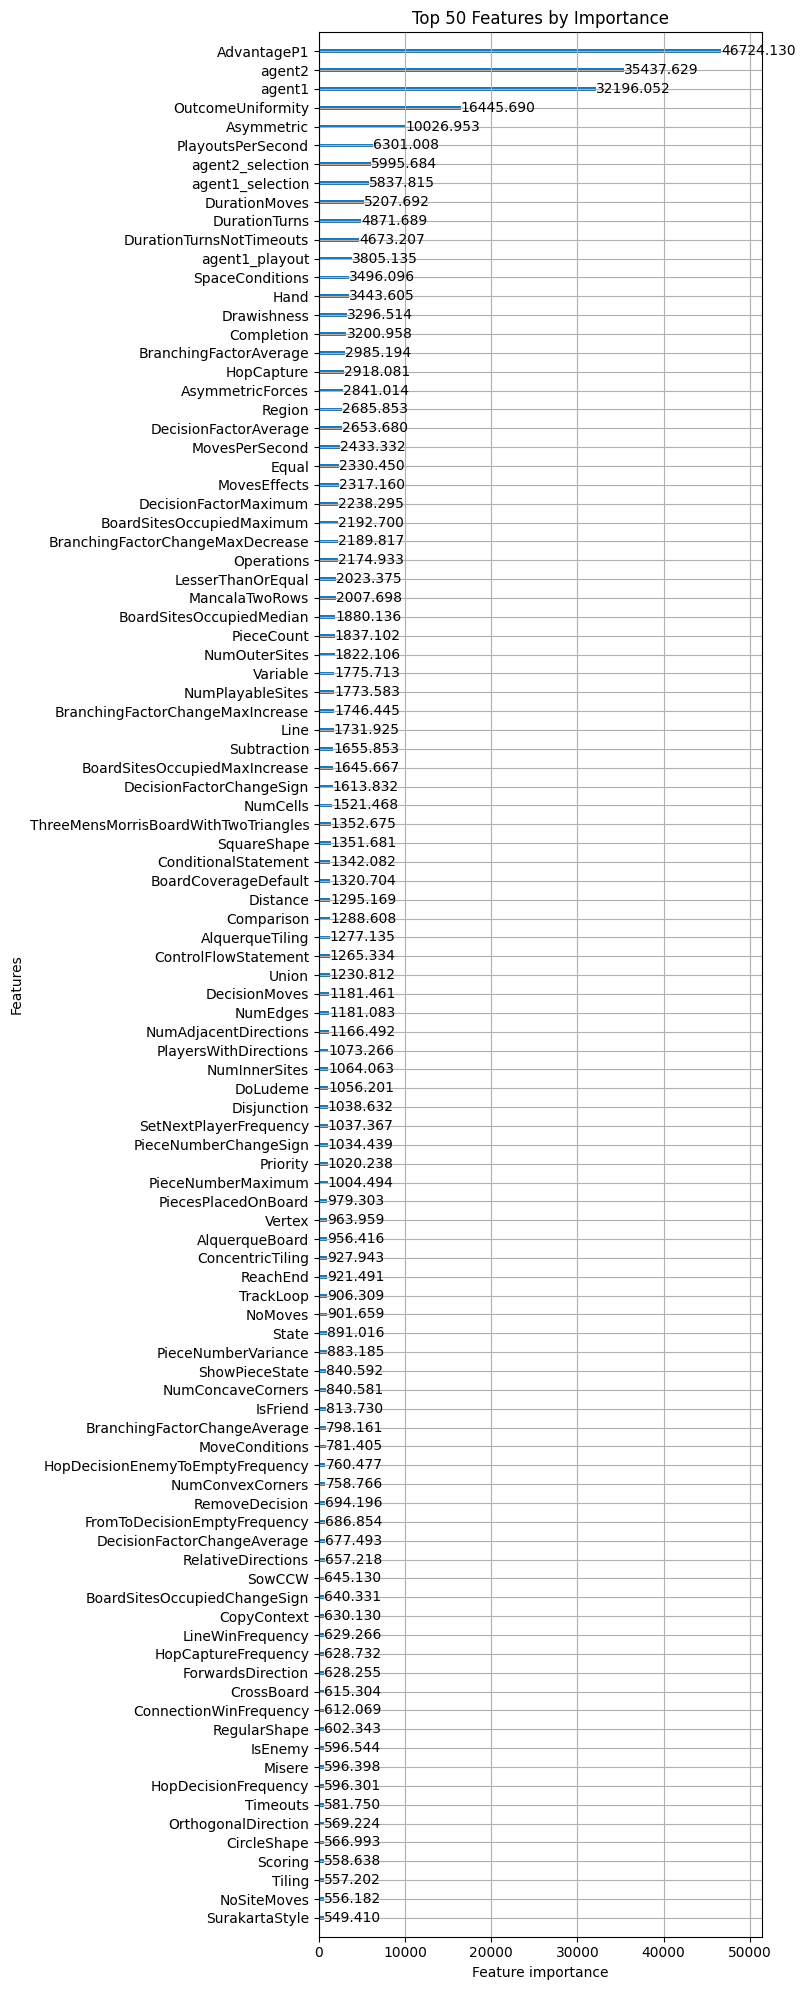

Fold 1 - RMSE: 0.4442268170859078
Fold 2


[50]	valid_0's rmse: 0.522144


[100]	valid_0's rmse: 0.50695


[150]	valid_0's rmse: 0.500626


[200]	valid_0's rmse: 0.495863


[250]	valid_0's rmse: 0.495022


[300]	valid_0's rmse: 0.494339


[350]	valid_0's rmse: 0.493053


[400]	valid_0's rmse: 0.491942


[450]	valid_0's rmse: 0.491786


[500]	valid_0's rmse: 0.490984


[550]	valid_0's rmse: 0.490051


[600]	valid_0's rmse: 0.489984


[650]	valid_0's rmse: 0.489086


[700]	valid_0's rmse: 0.488417


[750]	valid_0's rmse: 0.487489


[800]	valid_0's rmse: 0.486823


[850]	valid_0's rmse: 0.486182


[900]	valid_0's rmse: 0.485793


[950]	valid_0's rmse: 0.485119


[1000]	valid_0's rmse: 0.484789


[1050]	valid_0's rmse: 0.484213


[1100]	valid_0's rmse: 0.483956


[1150]	valid_0's rmse: 0.483983


[1200]	valid_0's rmse: 0.483612


[1250]	valid_0's rmse: 0.483137


[1300]	valid_0's rmse: 0.483011


[1350]	valid_0's rmse: 0.483289


[1400]	valid_0's rmse: 0.48326


[1450]	valid_0's rmse: 0.483137


[1500]	valid_0's rmse: 0.483139


[1550]	valid_0's rmse: 0.483045


[1600]	valid_0's rmse: 0.483129


[1650]	valid_0's rmse: 0.482803


[1700]	valid_0's rmse: 0.482737


[1750]	valid_0's rmse: 0.482816


[1800]	valid_0's rmse: 0.482889


[1850]	valid_0's rmse: 0.482935


[1900]	valid_0's rmse: 0.483017


[1950]	valid_0's rmse: 0.482897


[2000]	valid_0's rmse: 0.482884


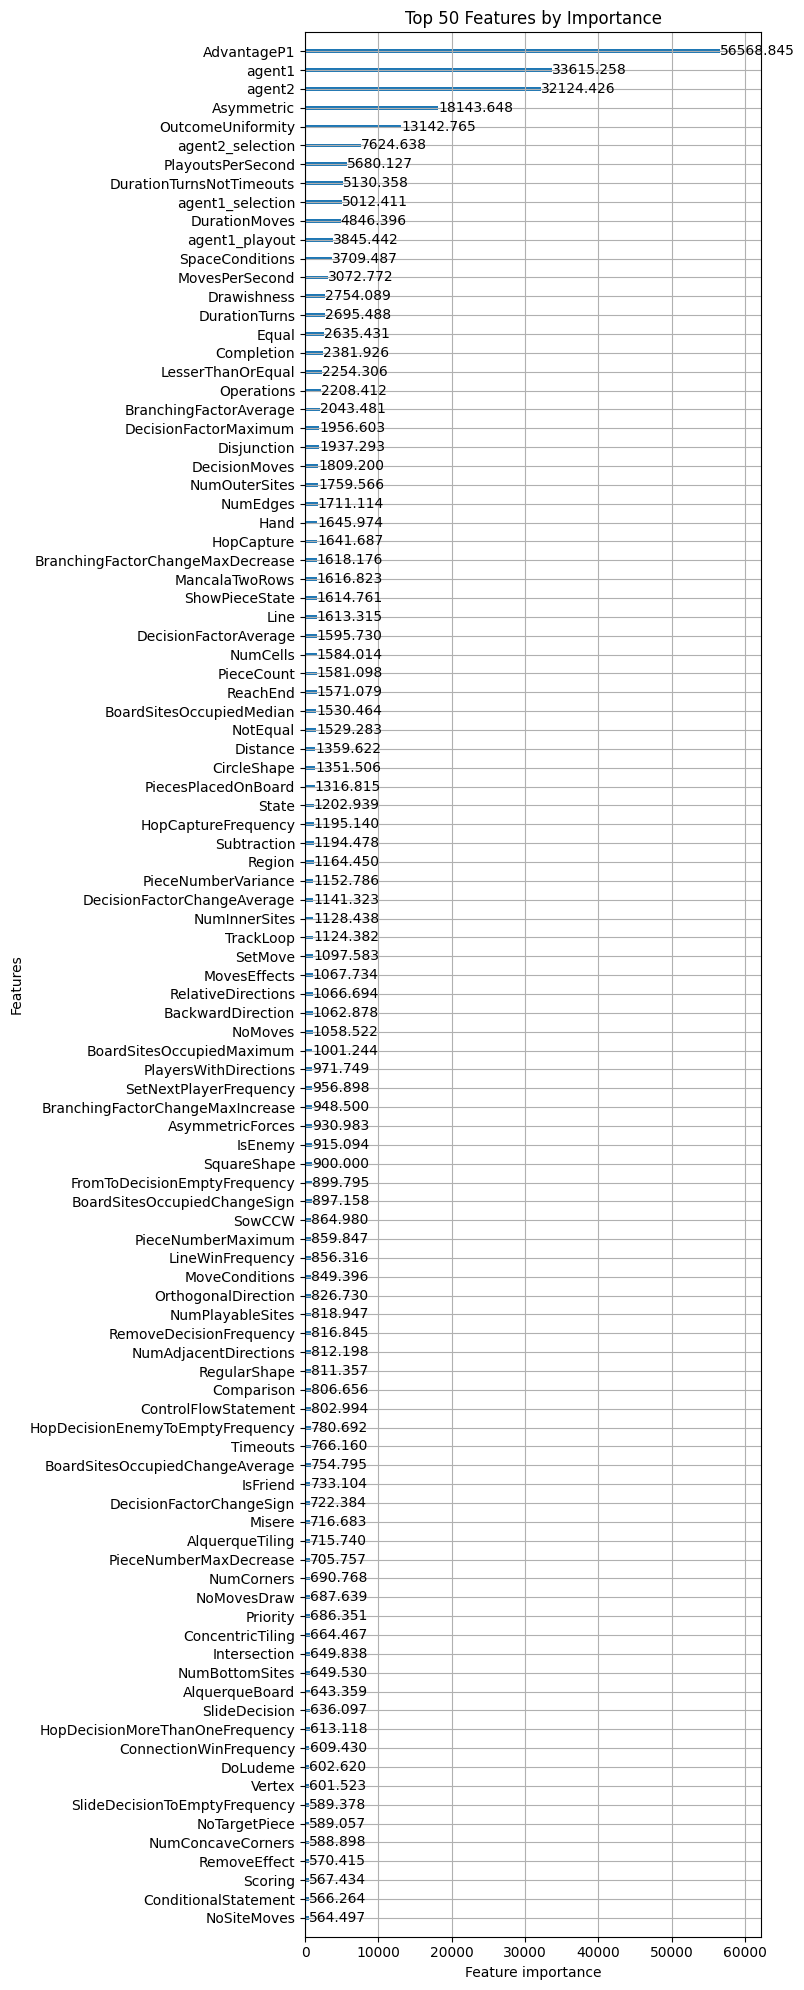

Fold 2 - RMSE: 0.4803229696810079
Fold 3


[50]	valid_0's rmse: 0.461227


[100]	valid_0's rmse: 0.444573


[150]	valid_0's rmse: 0.438152


[200]	valid_0's rmse: 0.432871


[250]	valid_0's rmse: 0.430786


[300]	valid_0's rmse: 0.428489


[350]	valid_0's rmse: 0.426942


[400]	valid_0's rmse: 0.42564


[450]	valid_0's rmse: 0.42444


[500]	valid_0's rmse: 0.42323


[550]	valid_0's rmse: 0.422833


[600]	valid_0's rmse: 0.422446


[650]	valid_0's rmse: 0.421859


[700]	valid_0's rmse: 0.421204


[750]	valid_0's rmse: 0.421038


[800]	valid_0's rmse: 0.420906


[850]	valid_0's rmse: 0.420331


[900]	valid_0's rmse: 0.420074


[950]	valid_0's rmse: 0.419937


[1000]	valid_0's rmse: 0.419989


[1050]	valid_0's rmse: 0.419749


[1100]	valid_0's rmse: 0.419332


[1150]	valid_0's rmse: 0.419354


[1200]	valid_0's rmse: 0.419488


[1250]	valid_0's rmse: 0.419229


[1300]	valid_0's rmse: 0.418784


[1350]	valid_0's rmse: 0.418583


[1400]	valid_0's rmse: 0.418456


[1450]	valid_0's rmse: 0.418392


[1500]	valid_0's rmse: 0.41842


[1550]	valid_0's rmse: 0.418381


[1600]	valid_0's rmse: 0.418256


[1650]	valid_0's rmse: 0.418243


[1700]	valid_0's rmse: 0.418189


[1750]	valid_0's rmse: 0.418189


[1800]	valid_0's rmse: 0.418035


[1850]	valid_0's rmse: 0.418024


[1900]	valid_0's rmse: 0.418034


[1950]	valid_0's rmse: 0.418041


[2000]	valid_0's rmse: 0.417916


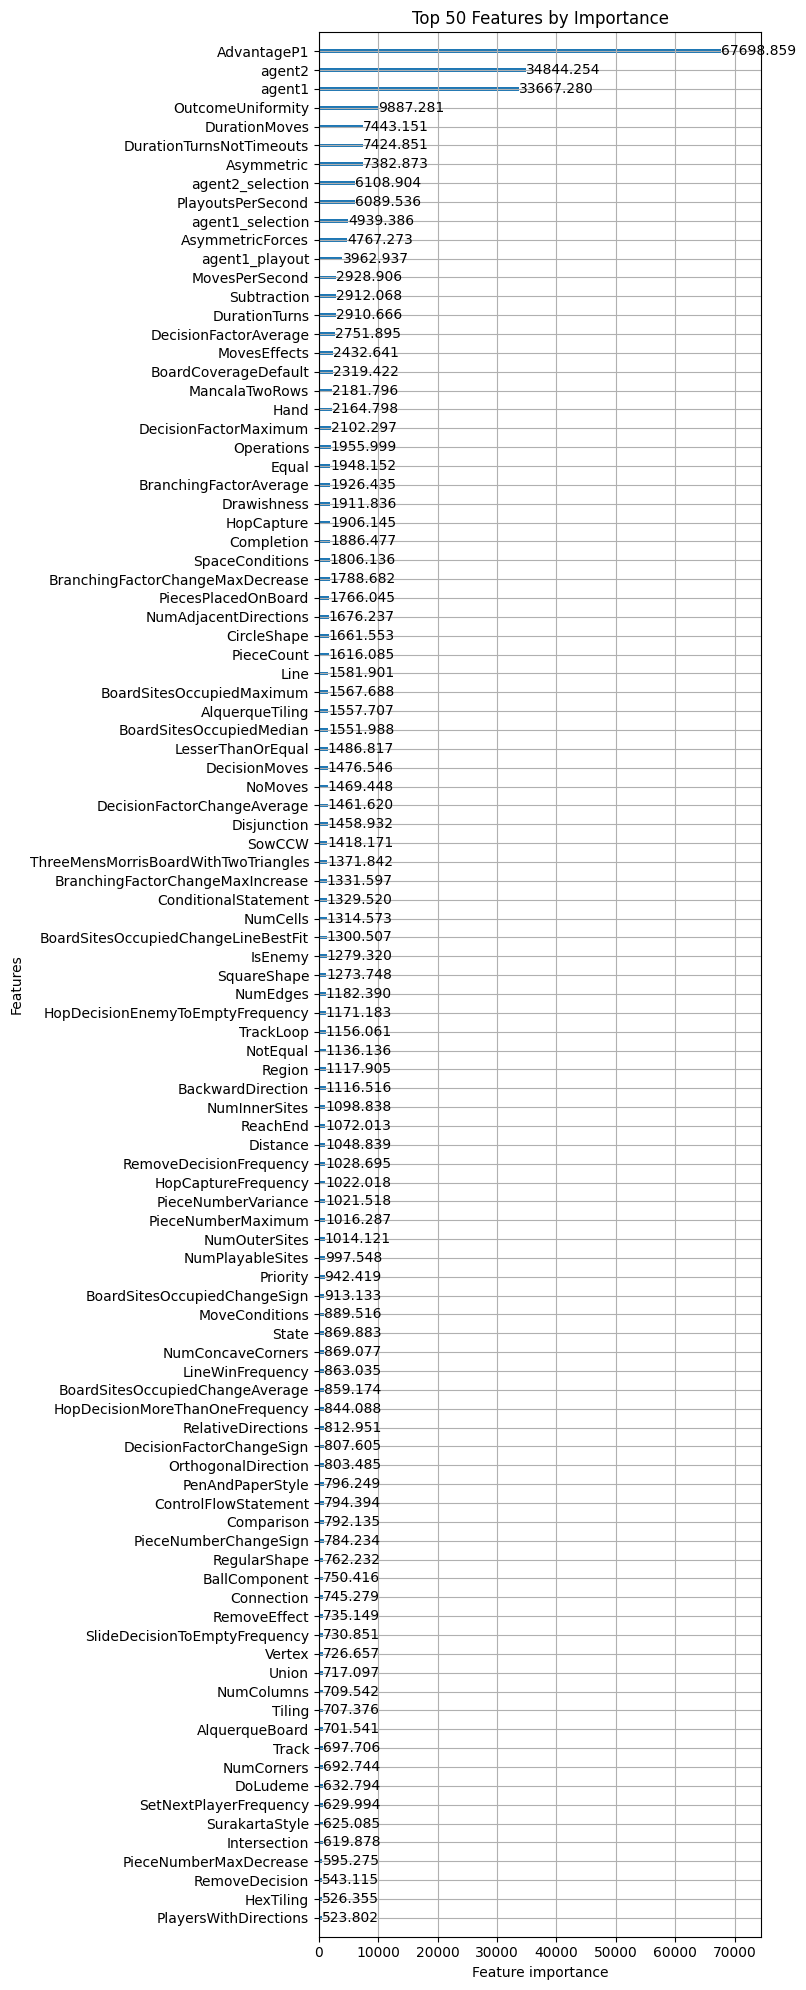

Fold 3 - RMSE: 0.4170911485029325
Fold 4


[50]	valid_0's rmse: 0.491198


[100]	valid_0's rmse: 0.477722


[150]	valid_0's rmse: 0.465362


[200]	valid_0's rmse: 0.460197


[250]	valid_0's rmse: 0.456434


[300]	valid_0's rmse: 0.454362


[350]	valid_0's rmse: 0.451767


[400]	valid_0's rmse: 0.450265


[450]	valid_0's rmse: 0.449212


[500]	valid_0's rmse: 0.447846


[550]	valid_0's rmse: 0.446413


[600]	valid_0's rmse: 0.445416


[650]	valid_0's rmse: 0.444549


[700]	valid_0's rmse: 0.443962


[750]	valid_0's rmse: 0.443739


[800]	valid_0's rmse: 0.443427


[850]	valid_0's rmse: 0.442392


[900]	valid_0's rmse: 0.442031


[950]	valid_0's rmse: 0.44185


[1000]	valid_0's rmse: 0.441593


[1050]	valid_0's rmse: 0.441182


[1100]	valid_0's rmse: 0.441049


[1150]	valid_0's rmse: 0.440835


[1200]	valid_0's rmse: 0.440685


[1250]	valid_0's rmse: 0.440448


[1300]	valid_0's rmse: 0.440407


[1350]	valid_0's rmse: 0.440346


[1400]	valid_0's rmse: 0.440154


[1450]	valid_0's rmse: 0.440039


[1500]	valid_0's rmse: 0.439992


[1550]	valid_0's rmse: 0.439896


[1600]	valid_0's rmse: 0.439603


[1650]	valid_0's rmse: 0.43965


[1700]	valid_0's rmse: 0.439539


[1750]	valid_0's rmse: 0.439349


[1800]	valid_0's rmse: 0.43923


[1850]	valid_0's rmse: 0.4393


[1900]	valid_0's rmse: 0.43921


[1950]	valid_0's rmse: 0.439198


[2000]	valid_0's rmse: 0.439396


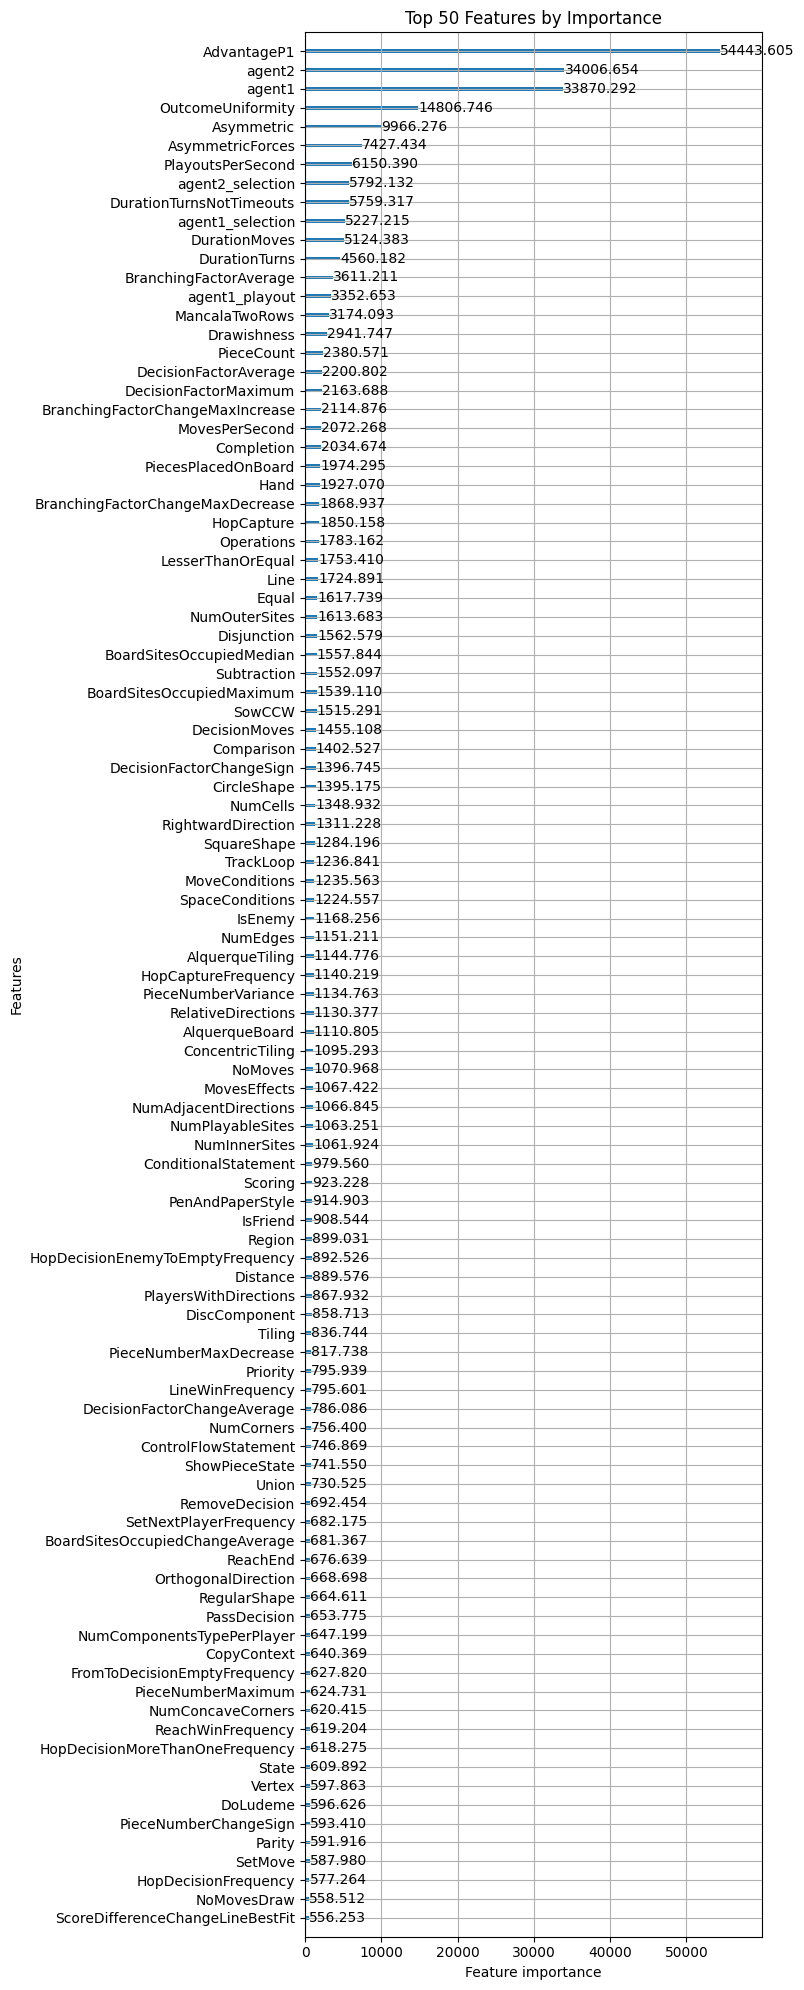

Fold 4 - RMSE: 0.43841794916769644
Fold 5


[50]	valid_0's rmse: 0.494082


[100]	valid_0's rmse: 0.481763


[150]	valid_0's rmse: 0.474819


[200]	valid_0's rmse: 0.469437


[250]	valid_0's rmse: 0.466349


[300]	valid_0's rmse: 0.464207


[350]	valid_0's rmse: 0.463543


[400]	valid_0's rmse: 0.463796


[450]	valid_0's rmse: 0.462524


[500]	valid_0's rmse: 0.461661


[550]	valid_0's rmse: 0.461373


[600]	valid_0's rmse: 0.460848


[650]	valid_0's rmse: 0.460665


[700]	valid_0's rmse: 0.459896


[750]	valid_0's rmse: 0.45971


[800]	valid_0's rmse: 0.459298


[850]	valid_0's rmse: 0.458777


[900]	valid_0's rmse: 0.458286


[950]	valid_0's rmse: 0.458056


[1000]	valid_0's rmse: 0.457902


[1050]	valid_0's rmse: 0.457991


[1100]	valid_0's rmse: 0.457735


[1150]	valid_0's rmse: 0.457534


[1200]	valid_0's rmse: 0.457157


[1250]	valid_0's rmse: 0.457248


[1300]	valid_0's rmse: 0.456941


[1350]	valid_0's rmse: 0.456706


[1400]	valid_0's rmse: 0.456591


[1450]	valid_0's rmse: 0.456736


[1500]	valid_0's rmse: 0.456584


[1550]	valid_0's rmse: 0.456354


[1600]	valid_0's rmse: 0.456406


[1650]	valid_0's rmse: 0.456406


[1700]	valid_0's rmse: 0.45618


[1750]	valid_0's rmse: 0.456163


[1800]	valid_0's rmse: 0.45622


[1850]	valid_0's rmse: 0.456099


[1900]	valid_0's rmse: 0.456251


[1950]	valid_0's rmse: 0.456198


[2000]	valid_0's rmse: 0.456042


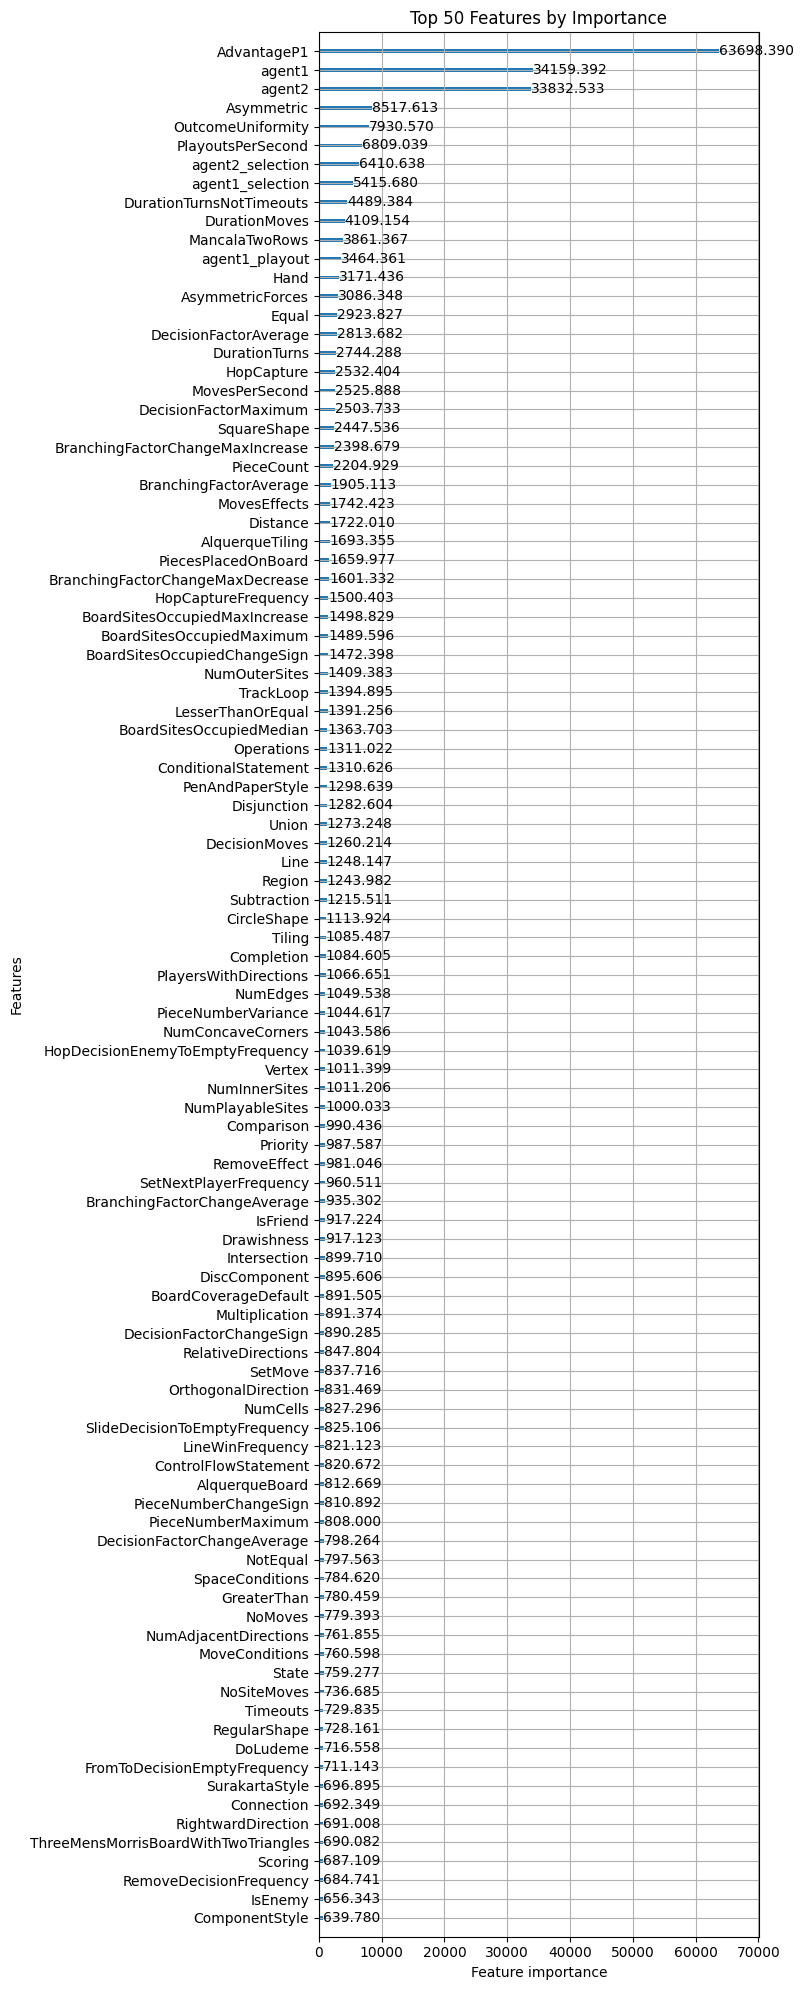

Fold 5 - RMSE: 0.4552404103011194
List of oof scores: [0.4442268170859078, 0.4803229696810079, 0.4170911485029325, 0.43841794916769644, 0.4552404103011194]
Average oof score: 0.4470598589477328


In [8]:
# call the function
trained_models1, oof1, oof_scores1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    num_folds=5,
    cv_random_state=2112,
)
# save oof predictions
oof1.to_csv(path_results / 'oof_lightgbm_cv1.csv', index=False)

/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1


[50]	valid_0's rmse: 0.477844


[100]	valid_0's rmse: 0.465398


[150]	valid_0's rmse: 0.457542


[200]	valid_0's rmse: 0.454409


[250]	valid_0's rmse: 0.452094


[300]	valid_0's rmse: 0.448406


[350]	valid_0's rmse: 0.447011


[400]	valid_0's rmse: 0.446257


[450]	valid_0's rmse: 0.445773


[500]	valid_0's rmse: 0.44498


[550]	valid_0's rmse: 0.444374


[600]	valid_0's rmse: 0.444266


[650]	valid_0's rmse: 0.44417


[700]	valid_0's rmse: 0.444648


[750]	valid_0's rmse: 0.444279


[800]	valid_0's rmse: 0.444121


[850]	valid_0's rmse: 0.443712


[900]	valid_0's rmse: 0.443635


[950]	valid_0's rmse: 0.443621


[1000]	valid_0's rmse: 0.443578


[1050]	valid_0's rmse: 0.443212


[1100]	valid_0's rmse: 0.442925


[1150]	valid_0's rmse: 0.442857


[1200]	valid_0's rmse: 0.442711


[1250]	valid_0's rmse: 0.442861


[1300]	valid_0's rmse: 0.4427


[1350]	valid_0's rmse: 0.442393


[1400]	valid_0's rmse: 0.442303


[1450]	valid_0's rmse: 0.442343


[1500]	valid_0's rmse: 0.44231


[1550]	valid_0's rmse: 0.442281


[1600]	valid_0's rmse: 0.442142


[1650]	valid_0's rmse: 0.442387


[1700]	valid_0's rmse: 0.442412


[1750]	valid_0's rmse: 0.442216


[1800]	valid_0's rmse: 0.442442


[1850]	valid_0's rmse: 0.442322


[1900]	valid_0's rmse: 0.442456


[1950]	valid_0's rmse: 0.442248


[2000]	valid_0's rmse: 0.442144


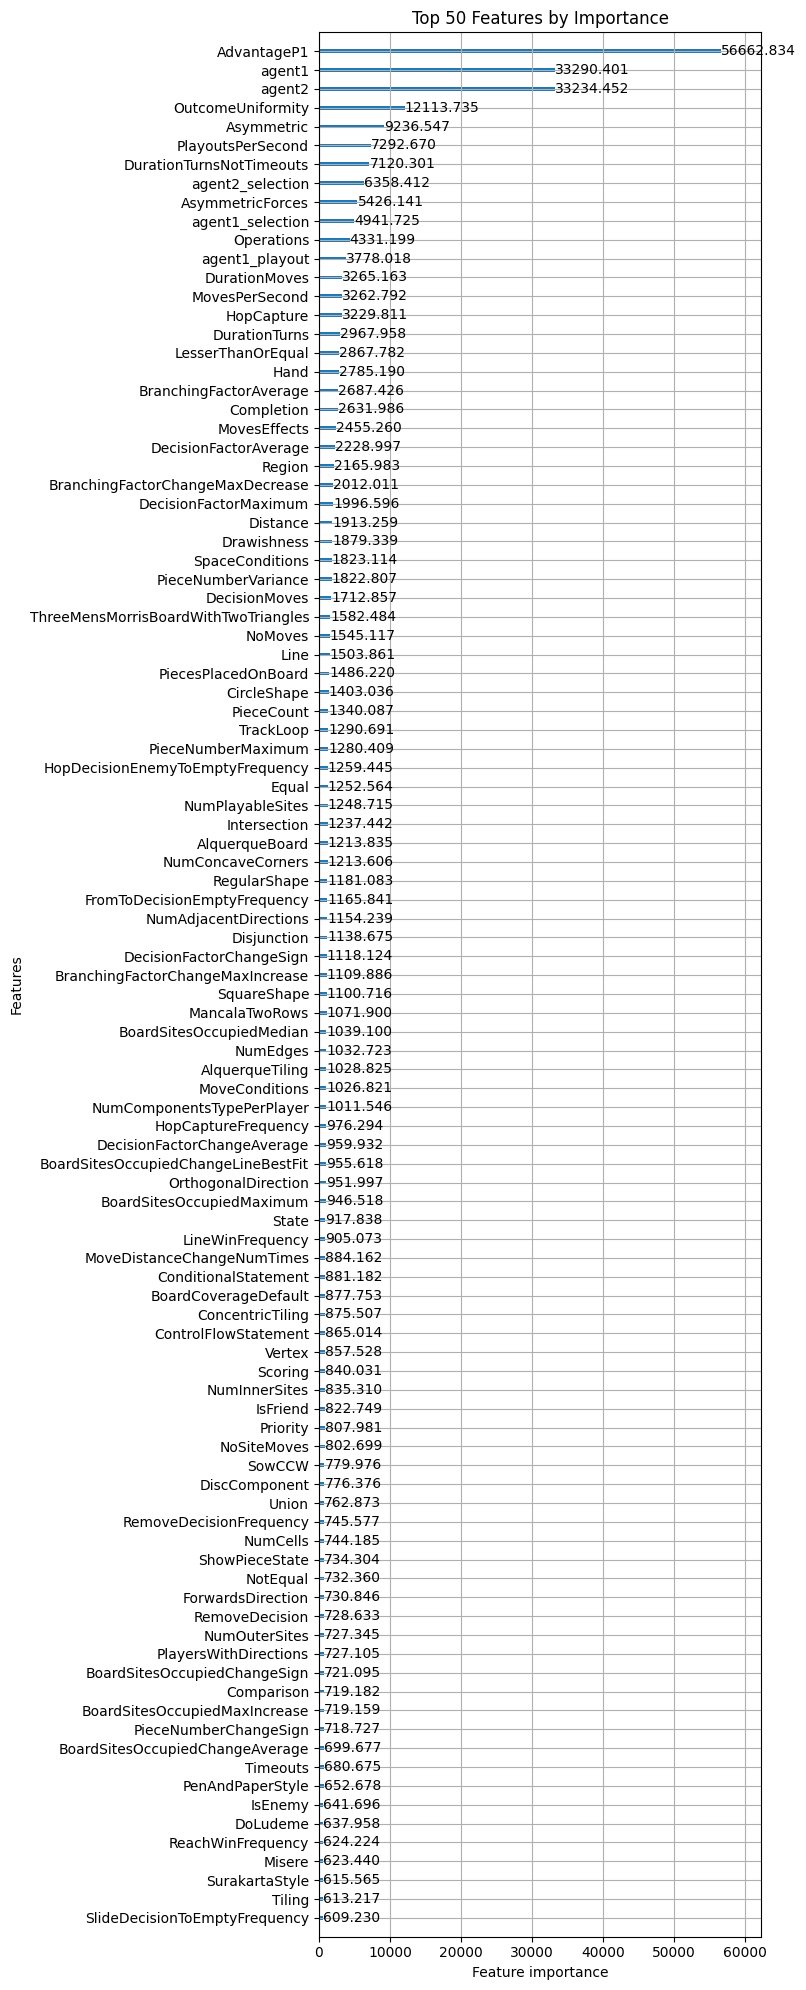

Fold 1 - RMSE: 0.4408360654653506
Fold 2


[50]	valid_0's rmse: 0.498026


[100]	valid_0's rmse: 0.489009


[150]	valid_0's rmse: 0.485226


[200]	valid_0's rmse: 0.486288


[250]	valid_0's rmse: 0.484304


[300]	valid_0's rmse: 0.481803


[350]	valid_0's rmse: 0.481703


[400]	valid_0's rmse: 0.480344


[450]	valid_0's rmse: 0.478539


[500]	valid_0's rmse: 0.478433


[550]	valid_0's rmse: 0.476984


[600]	valid_0's rmse: 0.477306


[650]	valid_0's rmse: 0.478053


[700]	valid_0's rmse: 0.478172


[750]	valid_0's rmse: 0.477982


[800]	valid_0's rmse: 0.477929


[850]	valid_0's rmse: 0.478037


[900]	valid_0's rmse: 0.477917


[950]	valid_0's rmse: 0.477834


[1000]	valid_0's rmse: 0.477767


[1050]	valid_0's rmse: 0.477651


[1100]	valid_0's rmse: 0.47749


[1150]	valid_0's rmse: 0.477304


[1200]	valid_0's rmse: 0.477282


[1250]	valid_0's rmse: 0.4774


[1300]	valid_0's rmse: 0.477322


[1350]	valid_0's rmse: 0.477247


[1400]	valid_0's rmse: 0.477237


[1450]	valid_0's rmse: 0.47704


[1500]	valid_0's rmse: 0.477011


[1550]	valid_0's rmse: 0.476995


[1600]	valid_0's rmse: 0.477076


[1650]	valid_0's rmse: 0.476907


[1700]	valid_0's rmse: 0.476781


[1750]	valid_0's rmse: 0.476848


[1800]	valid_0's rmse: 0.476888


[1850]	valid_0's rmse: 0.476879


[1900]	valid_0's rmse: 0.476882


[1950]	valid_0's rmse: 0.476949


[2000]	valid_0's rmse: 0.477031


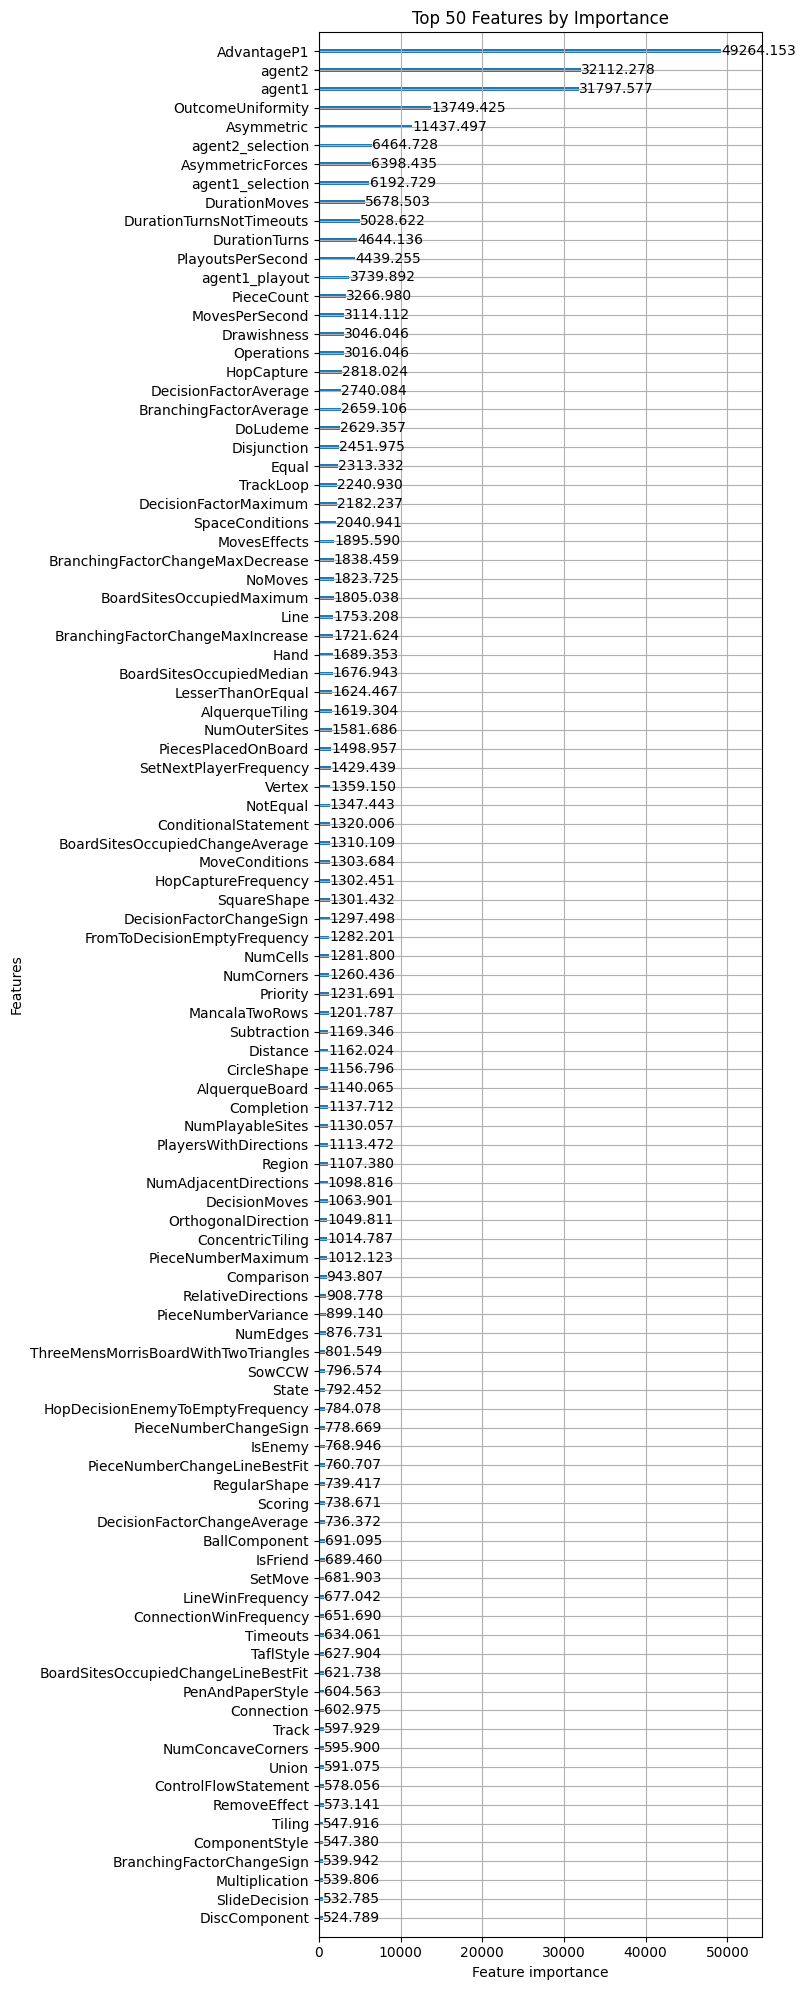

Fold 2 - RMSE: 0.47490751221234795
Fold 3


[50]	valid_0's rmse: 0.493334


[100]	valid_0's rmse: 0.481147


[150]	valid_0's rmse: 0.478724


[200]	valid_0's rmse: 0.476132


[250]	valid_0's rmse: 0.473615


[300]	valid_0's rmse: 0.471114


[350]	valid_0's rmse: 0.468525


[400]	valid_0's rmse: 0.467305


[450]	valid_0's rmse: 0.466656


[500]	valid_0's rmse: 0.465645


[550]	valid_0's rmse: 0.465185


[600]	valid_0's rmse: 0.464585


[650]	valid_0's rmse: 0.463784


[700]	valid_0's rmse: 0.463266


[750]	valid_0's rmse: 0.463022


[800]	valid_0's rmse: 0.462502


[850]	valid_0's rmse: 0.462226


[900]	valid_0's rmse: 0.461934


[950]	valid_0's rmse: 0.462116


[1000]	valid_0's rmse: 0.461875


[1050]	valid_0's rmse: 0.461082


[1100]	valid_0's rmse: 0.461129


[1150]	valid_0's rmse: 0.461031


[1200]	valid_0's rmse: 0.460641


[1250]	valid_0's rmse: 0.460346


[1300]	valid_0's rmse: 0.459878


[1350]	valid_0's rmse: 0.460032


[1400]	valid_0's rmse: 0.459953


[1450]	valid_0's rmse: 0.459833


[1500]	valid_0's rmse: 0.459811


[1550]	valid_0's rmse: 0.459685


[1600]	valid_0's rmse: 0.459574


[1650]	valid_0's rmse: 0.45956


[1700]	valid_0's rmse: 0.459618


[1750]	valid_0's rmse: 0.459381


[1800]	valid_0's rmse: 0.459298


[1850]	valid_0's rmse: 0.459423


[1900]	valid_0's rmse: 0.459361


[1950]	valid_0's rmse: 0.459275


[2000]	valid_0's rmse: 0.459289


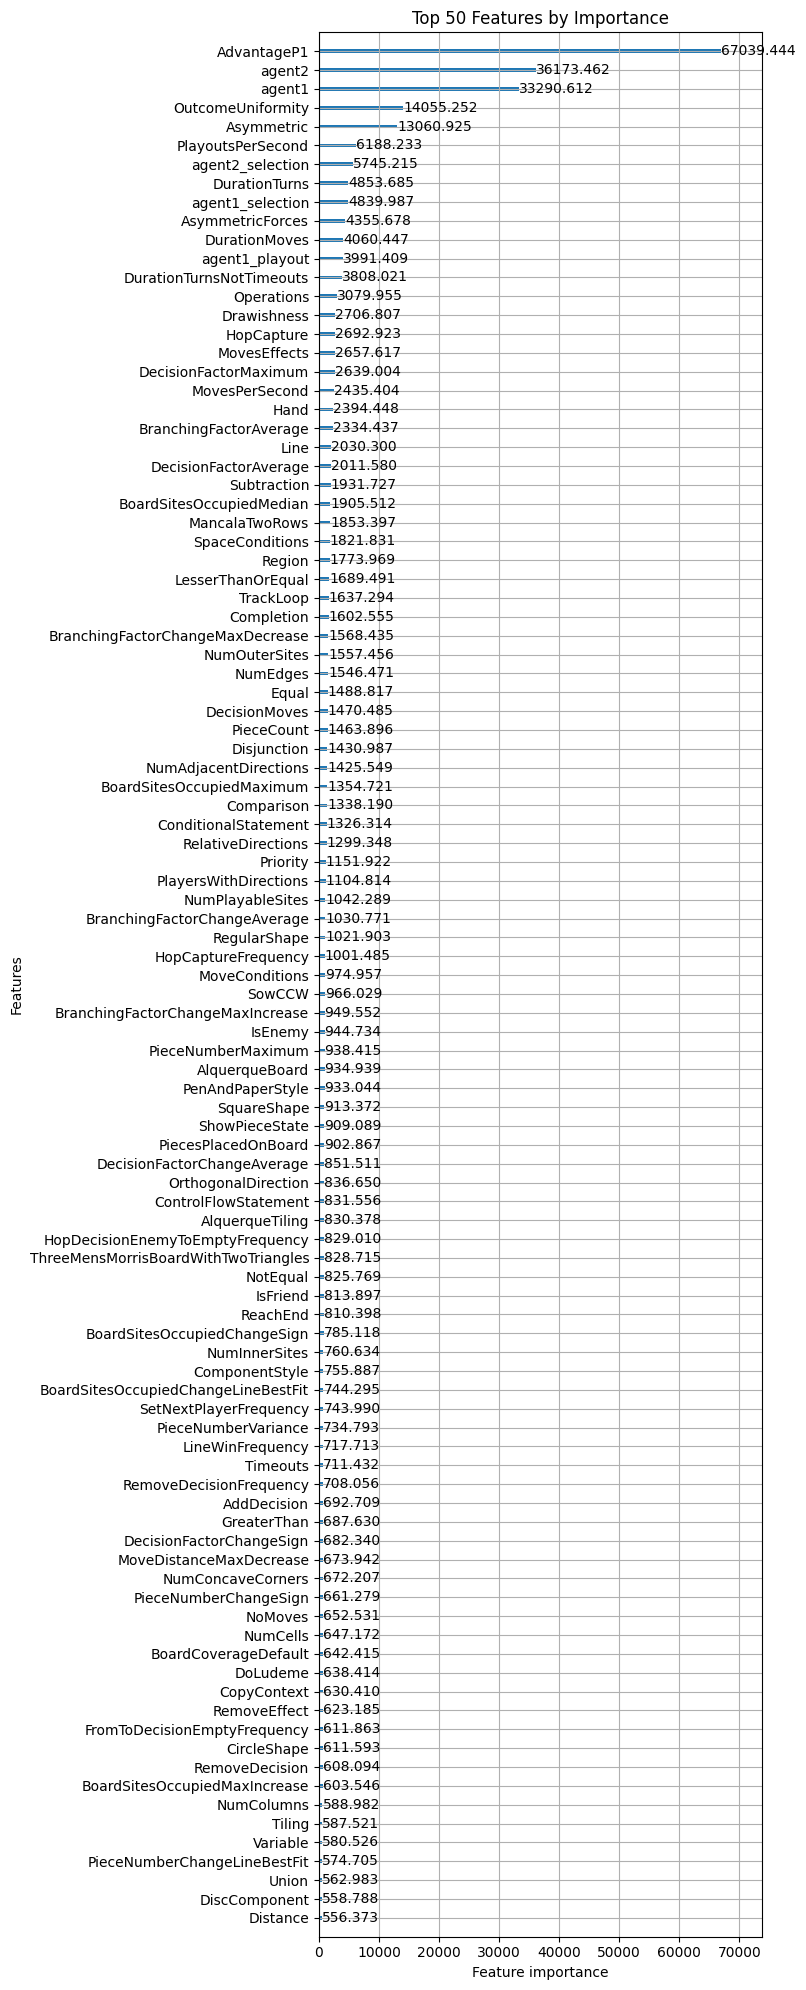

Fold 3 - RMSE: 0.458172132927187
Fold 4


[50]	valid_0's rmse: 0.49544


[100]	valid_0's rmse: 0.480154


[150]	valid_0's rmse: 0.474763


[200]	valid_0's rmse: 0.47038


[250]	valid_0's rmse: 0.46782


[300]	valid_0's rmse: 0.465729


[350]	valid_0's rmse: 0.464258


[400]	valid_0's rmse: 0.462775


[450]	valid_0's rmse: 0.461767


[500]	valid_0's rmse: 0.461398


[550]	valid_0's rmse: 0.46073


[600]	valid_0's rmse: 0.460169


[650]	valid_0's rmse: 0.459745


[700]	valid_0's rmse: 0.459776


[750]	valid_0's rmse: 0.459432


[800]	valid_0's rmse: 0.459091


[850]	valid_0's rmse: 0.45871


[900]	valid_0's rmse: 0.458228


[950]	valid_0's rmse: 0.457878


[1000]	valid_0's rmse: 0.457548


[1050]	valid_0's rmse: 0.4574


[1100]	valid_0's rmse: 0.457331


[1150]	valid_0's rmse: 0.457248


[1200]	valid_0's rmse: 0.456906


[1250]	valid_0's rmse: 0.456915


[1300]	valid_0's rmse: 0.456912


[1350]	valid_0's rmse: 0.457011


[1400]	valid_0's rmse: 0.457068


[1450]	valid_0's rmse: 0.456865


[1500]	valid_0's rmse: 0.456625


[1550]	valid_0's rmse: 0.456617


[1600]	valid_0's rmse: 0.456588


[1650]	valid_0's rmse: 0.456488


[1700]	valid_0's rmse: 0.456353


[1750]	valid_0's rmse: 0.456245


[1800]	valid_0's rmse: 0.45623


[1850]	valid_0's rmse: 0.456023


[1900]	valid_0's rmse: 0.455996


[1950]	valid_0's rmse: 0.456067


[2000]	valid_0's rmse: 0.456077


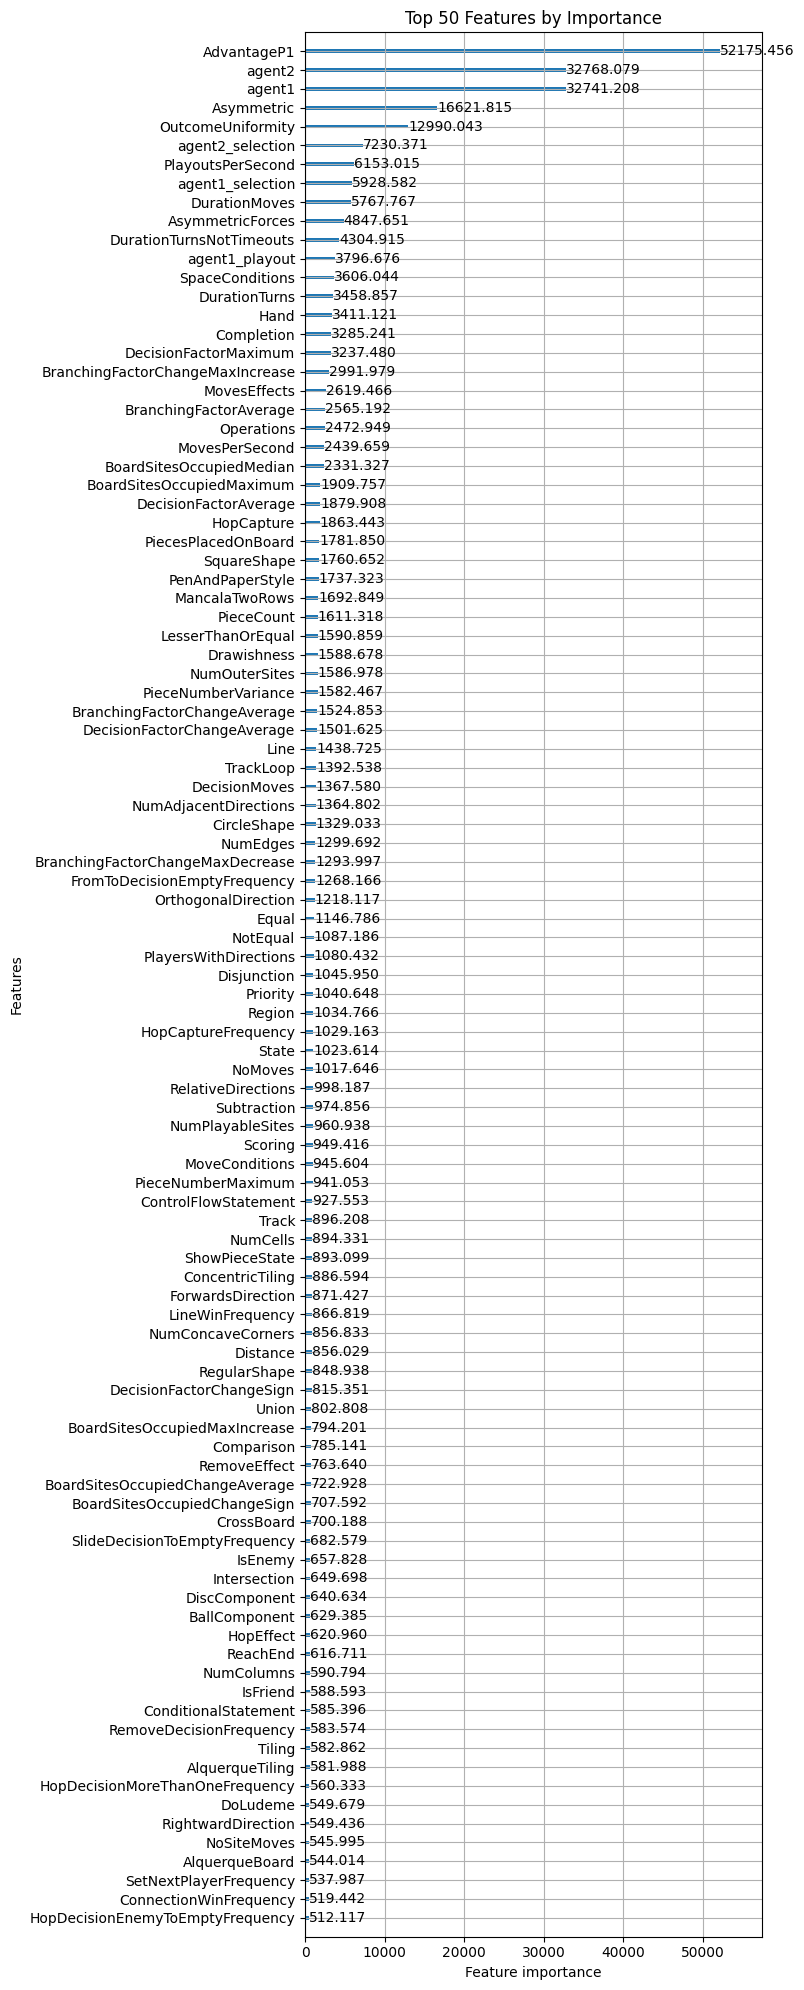

Fold 4 - RMSE: 0.4547373474280227
Fold 5


[50]	valid_0's rmse: 0.498605


[100]	valid_0's rmse: 0.486532


[150]	valid_0's rmse: 0.48182


[200]	valid_0's rmse: 0.477815


[250]	valid_0's rmse: 0.474654


[300]	valid_0's rmse: 0.472621


[350]	valid_0's rmse: 0.472607


[400]	valid_0's rmse: 0.471367


[450]	valid_0's rmse: 0.471171


[500]	valid_0's rmse: 0.470545


[550]	valid_0's rmse: 0.470096


[600]	valid_0's rmse: 0.469151


[650]	valid_0's rmse: 0.469512


[700]	valid_0's rmse: 0.468874


[750]	valid_0's rmse: 0.468395


[800]	valid_0's rmse: 0.468114


[850]	valid_0's rmse: 0.467818


[900]	valid_0's rmse: 0.46757


[950]	valid_0's rmse: 0.467899


[1000]	valid_0's rmse: 0.468028


[1050]	valid_0's rmse: 0.467964


[1100]	valid_0's rmse: 0.467933


[1150]	valid_0's rmse: 0.467838


[1200]	valid_0's rmse: 0.467834


[1250]	valid_0's rmse: 0.467672


[1300]	valid_0's rmse: 0.467687


[1350]	valid_0's rmse: 0.467826


[1400]	valid_0's rmse: 0.467686


[1450]	valid_0's rmse: 0.467496


[1500]	valid_0's rmse: 0.467548


[1550]	valid_0's rmse: 0.467369


[1600]	valid_0's rmse: 0.467316


[1650]	valid_0's rmse: 0.467412


[1700]	valid_0's rmse: 0.467291


[1750]	valid_0's rmse: 0.467357


[1800]	valid_0's rmse: 0.467151


[1850]	valid_0's rmse: 0.467243


[1900]	valid_0's rmse: 0.467312


[1950]	valid_0's rmse: 0.467509


[2000]	valid_0's rmse: 0.4675


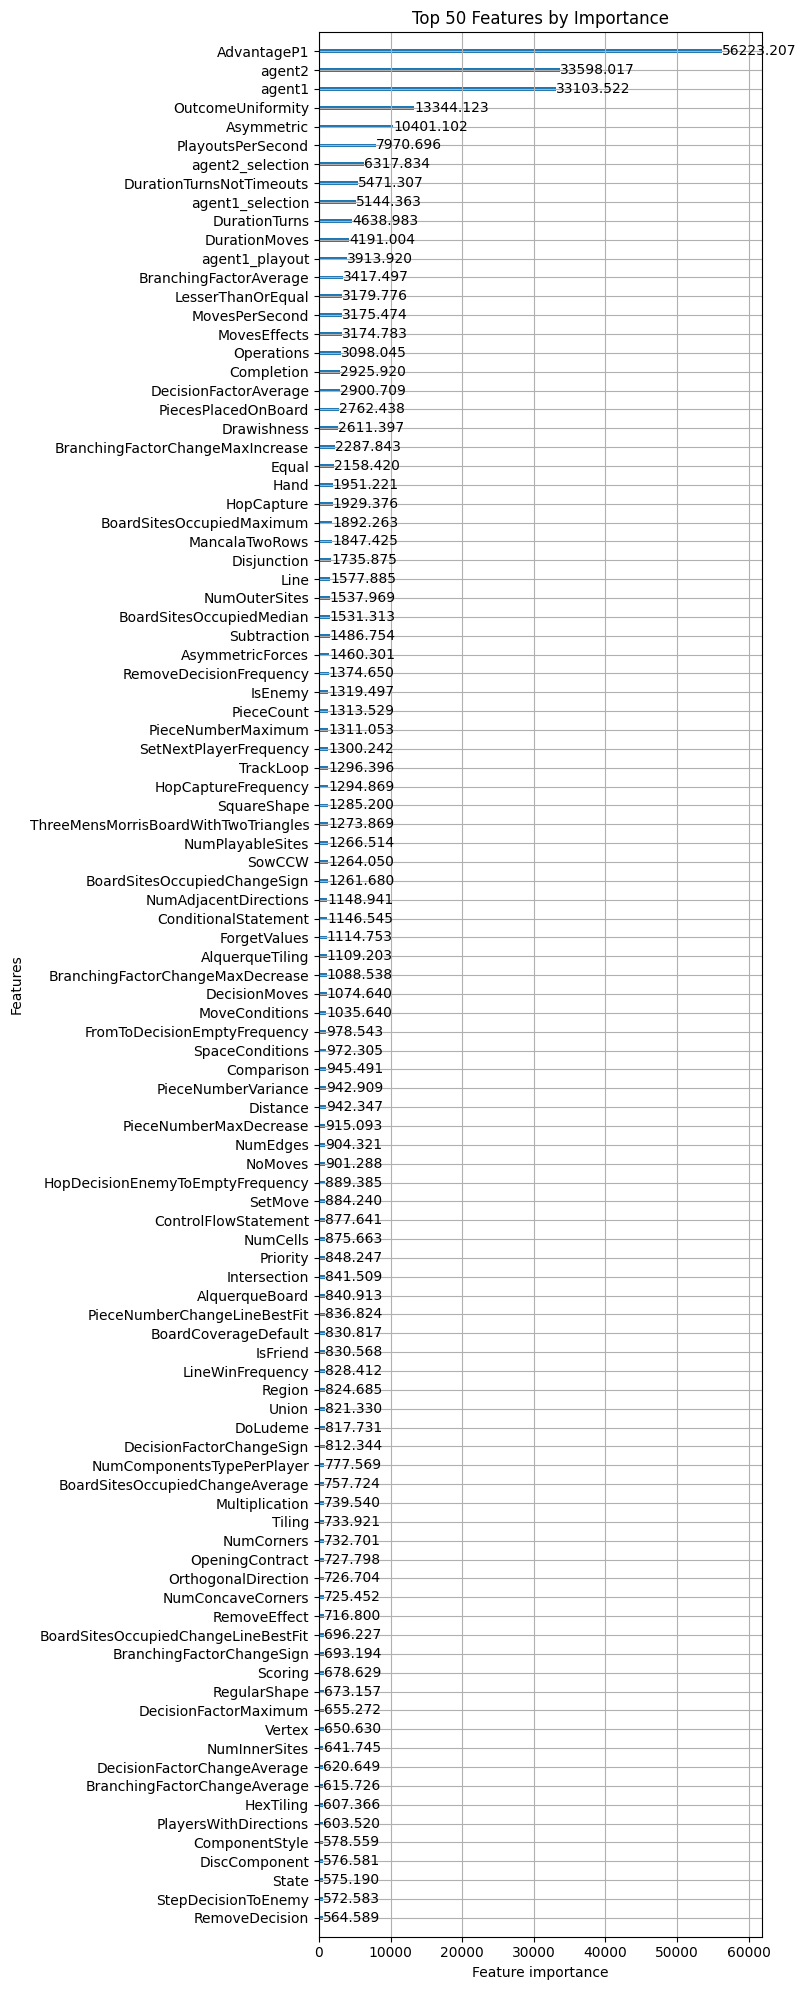

Fold 5 - RMSE: 0.466264407902186
List of oof scores: [0.4408360654653506, 0.47490751221234795, 0.458172132927187, 0.4547373474280227, 0.466264407902186]
Average oof score: 0.45898349318701887


In [9]:
# call the function
trained_models2, oof2, oof_scores2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    num_folds=5,
    cv_random_state=19,
)
# save oof predictions
oof2.to_csv(path_results / 'oof_lightgbm_cv2.csv', index=False)

/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/model_selection/_split.py:909: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold 1


[50]	valid_0's rmse: 0.491572


[100]	valid_0's rmse: 0.477813


[150]	valid_0's rmse: 0.472605


[200]	valid_0's rmse: 0.47024


[250]	valid_0's rmse: 0.468097


[300]	valid_0's rmse: 0.466006


[350]	valid_0's rmse: 0.464188


[400]	valid_0's rmse: 0.463081


[450]	valid_0's rmse: 0.461618


[500]	valid_0's rmse: 0.460244


[550]	valid_0's rmse: 0.460505


[600]	valid_0's rmse: 0.460276


[650]	valid_0's rmse: 0.46004


[700]	valid_0's rmse: 0.459388


[750]	valid_0's rmse: 0.459073


[800]	valid_0's rmse: 0.458414


[850]	valid_0's rmse: 0.458039


[900]	valid_0's rmse: 0.457679


[950]	valid_0's rmse: 0.457531


[1000]	valid_0's rmse: 0.457338


[1050]	valid_0's rmse: 0.457171


[1100]	valid_0's rmse: 0.457054


[1150]	valid_0's rmse: 0.456573


[1200]	valid_0's rmse: 0.456586


[1250]	valid_0's rmse: 0.45632


[1300]	valid_0's rmse: 0.456286


[1350]	valid_0's rmse: 0.456526


[1400]	valid_0's rmse: 0.456387


[1450]	valid_0's rmse: 0.45633


[1500]	valid_0's rmse: 0.45614


[1550]	valid_0's rmse: 0.456163


[1600]	valid_0's rmse: 0.456001


[1650]	valid_0's rmse: 0.455941


[1700]	valid_0's rmse: 0.455786


[1750]	valid_0's rmse: 0.455534


[1800]	valid_0's rmse: 0.455366


[1850]	valid_0's rmse: 0.455489


[1900]	valid_0's rmse: 0.455563


[1950]	valid_0's rmse: 0.455625


[2000]	valid_0's rmse: 0.4556


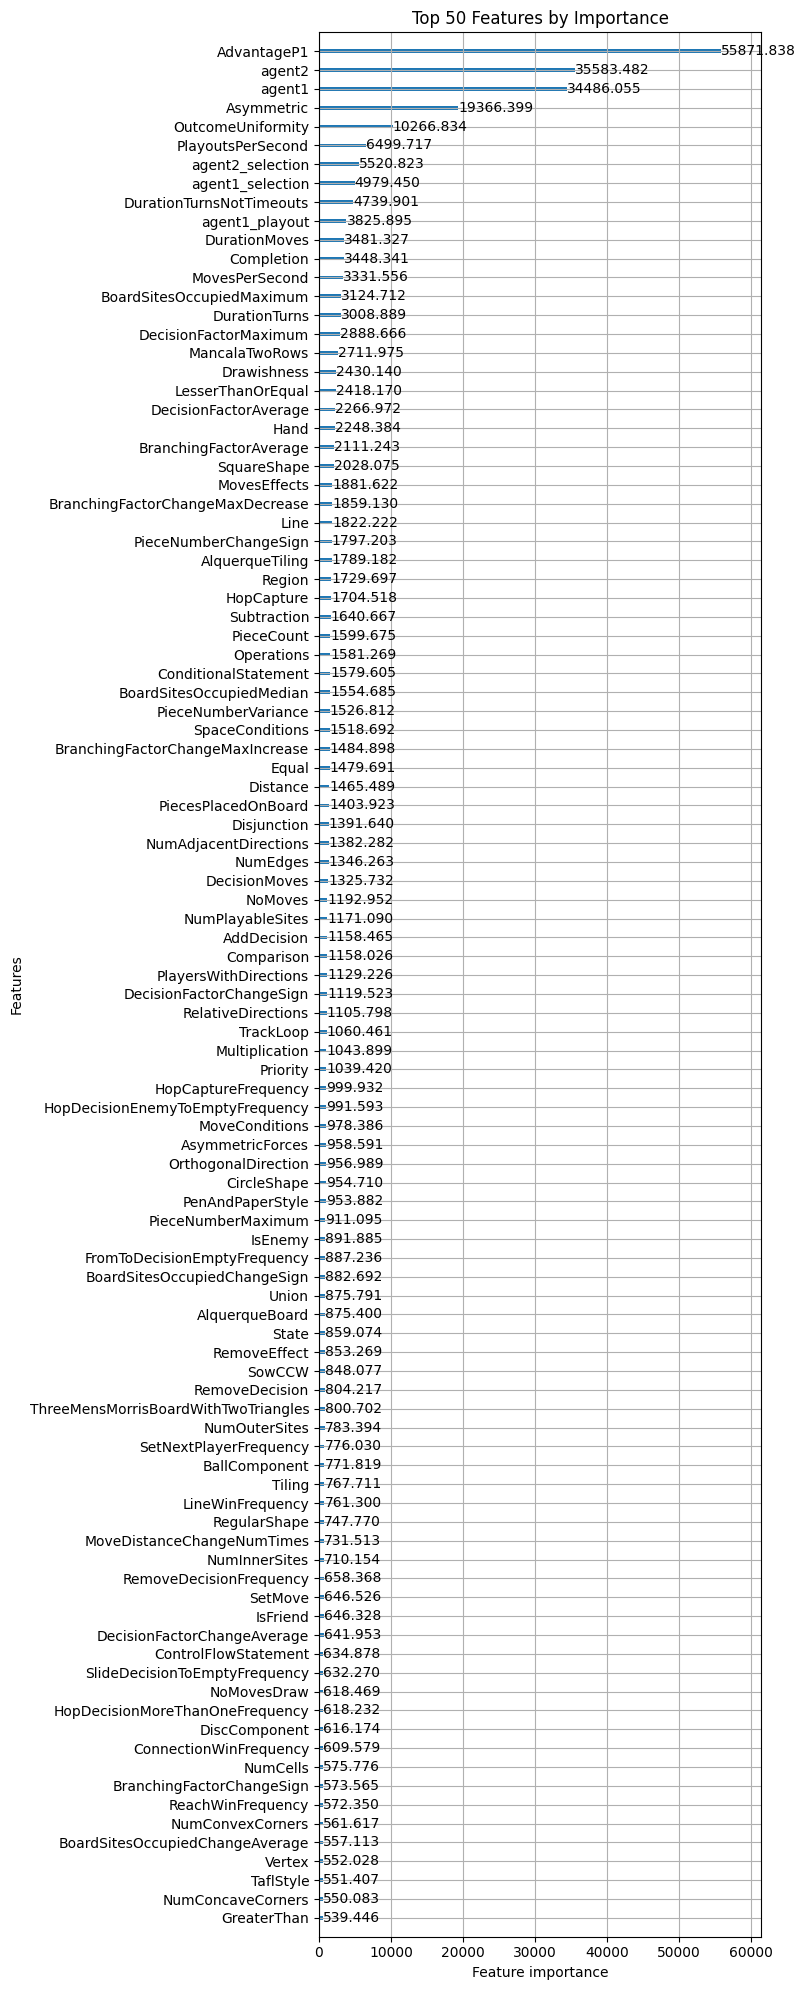

Fold 1 - RMSE: 0.4545684219948849
Fold 2


[50]	valid_0's rmse: 0.50345


[100]	valid_0's rmse: 0.493439


[150]	valid_0's rmse: 0.493036


[200]	valid_0's rmse: 0.492651


[250]	valid_0's rmse: 0.490749


[300]	valid_0's rmse: 0.488899


[350]	valid_0's rmse: 0.487933


[400]	valid_0's rmse: 0.487749


[450]	valid_0's rmse: 0.486306


[500]	valid_0's rmse: 0.485471


[550]	valid_0's rmse: 0.484876


[600]	valid_0's rmse: 0.484982


[650]	valid_0's rmse: 0.485074


[700]	valid_0's rmse: 0.484979


[750]	valid_0's rmse: 0.484765


[800]	valid_0's rmse: 0.484648


[850]	valid_0's rmse: 0.484509


[900]	valid_0's rmse: 0.483957


[950]	valid_0's rmse: 0.483392


[1000]	valid_0's rmse: 0.483278


[1050]	valid_0's rmse: 0.48313


[1100]	valid_0's rmse: 0.482906


[1150]	valid_0's rmse: 0.482703


[1200]	valid_0's rmse: 0.482839


[1250]	valid_0's rmse: 0.482682


[1300]	valid_0's rmse: 0.482605


[1350]	valid_0's rmse: 0.482853


[1400]	valid_0's rmse: 0.482567


[1450]	valid_0's rmse: 0.4827


[1500]	valid_0's rmse: 0.482699


[1550]	valid_0's rmse: 0.482658


[1600]	valid_0's rmse: 0.482612


[1650]	valid_0's rmse: 0.482668


[1700]	valid_0's rmse: 0.482539


[1750]	valid_0's rmse: 0.4825


[1800]	valid_0's rmse: 0.482457


[1850]	valid_0's rmse: 0.482395


[1900]	valid_0's rmse: 0.482456


[1950]	valid_0's rmse: 0.482323


[2000]	valid_0's rmse: 0.482227


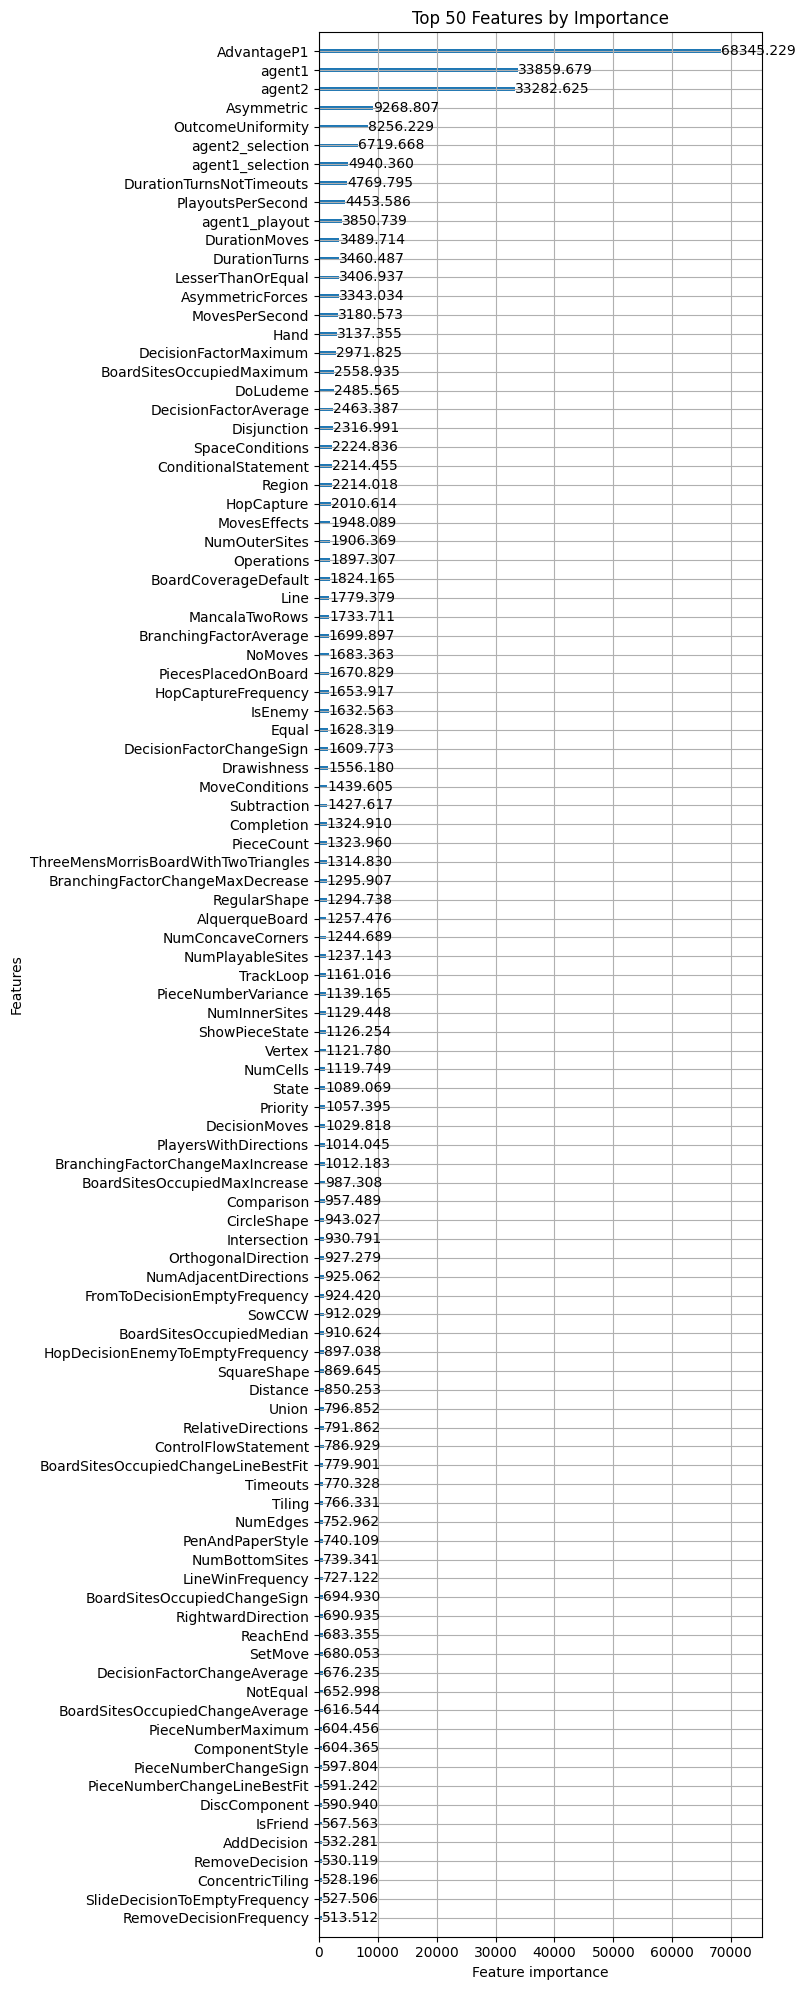

Fold 2 - RMSE: 0.48150048506810533
Fold 3


[50]	valid_0's rmse: 0.481838


[100]	valid_0's rmse: 0.459441


[150]	valid_0's rmse: 0.449808


[200]	valid_0's rmse: 0.444426


[250]	valid_0's rmse: 0.4411


[300]	valid_0's rmse: 0.438724


[350]	valid_0's rmse: 0.438516


[400]	valid_0's rmse: 0.437441


[450]	valid_0's rmse: 0.436074


[500]	valid_0's rmse: 0.435478


[550]	valid_0's rmse: 0.434692


[600]	valid_0's rmse: 0.434492


[650]	valid_0's rmse: 0.434151


[700]	valid_0's rmse: 0.434084


[750]	valid_0's rmse: 0.433703


[800]	valid_0's rmse: 0.43337


[850]	valid_0's rmse: 0.43321


[900]	valid_0's rmse: 0.432669


[950]	valid_0's rmse: 0.432193


[1000]	valid_0's rmse: 0.432143


[1050]	valid_0's rmse: 0.431757


[1100]	valid_0's rmse: 0.431472


[1150]	valid_0's rmse: 0.431482


[1200]	valid_0's rmse: 0.431539


[1250]	valid_0's rmse: 0.431986


[1300]	valid_0's rmse: 0.431818


[1350]	valid_0's rmse: 0.431807


[1400]	valid_0's rmse: 0.431515


[1450]	valid_0's rmse: 0.431659


[1500]	valid_0's rmse: 0.431776


[1550]	valid_0's rmse: 0.431603


[1600]	valid_0's rmse: 0.431563


[1650]	valid_0's rmse: 0.431486


[1700]	valid_0's rmse: 0.431401


[1750]	valid_0's rmse: 0.431761


[1800]	valid_0's rmse: 0.431882


[1850]	valid_0's rmse: 0.43192


[1900]	valid_0's rmse: 0.432009


[1950]	valid_0's rmse: 0.431976


[2000]	valid_0's rmse: 0.431995


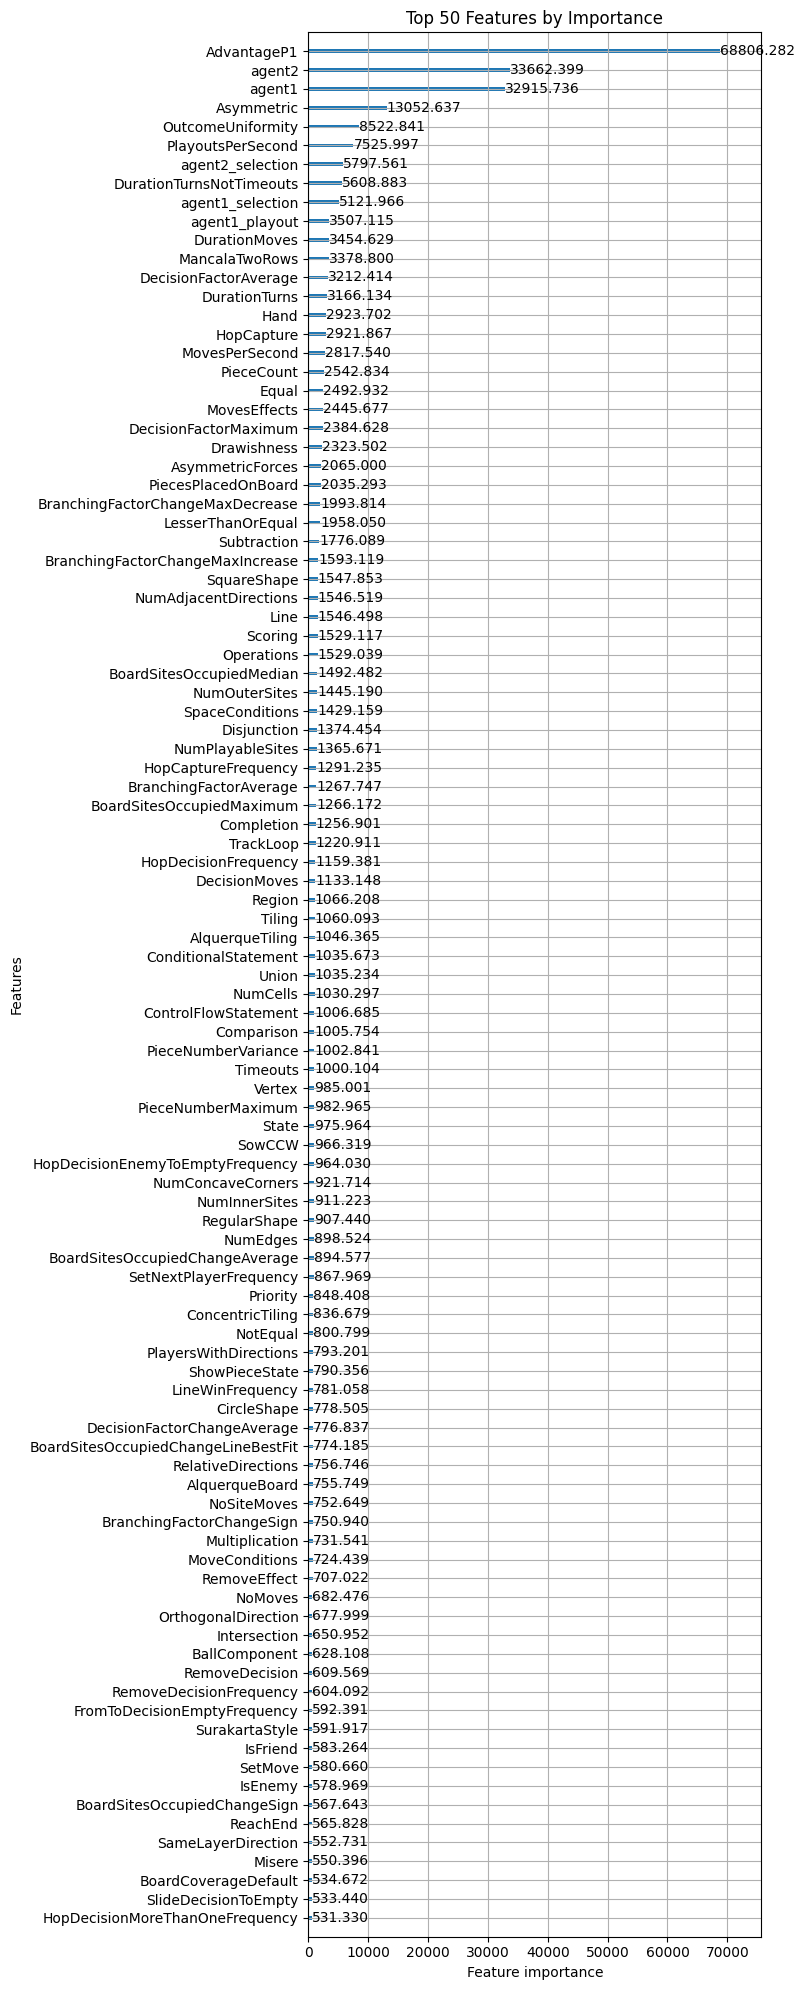

Fold 3 - RMSE: 0.43102493775591777
Fold 4


[50]	valid_0's rmse: 0.486286


[100]	valid_0's rmse: 0.470819


[150]	valid_0's rmse: 0.462031


[200]	valid_0's rmse: 0.459055


[250]	valid_0's rmse: 0.454345


[300]	valid_0's rmse: 0.452012


[350]	valid_0's rmse: 0.451168


[400]	valid_0's rmse: 0.448819


[450]	valid_0's rmse: 0.448182


[500]	valid_0's rmse: 0.447274


[550]	valid_0's rmse: 0.446655


[600]	valid_0's rmse: 0.445732


[650]	valid_0's rmse: 0.445052


[700]	valid_0's rmse: 0.444514


[750]	valid_0's rmse: 0.444261


[800]	valid_0's rmse: 0.443852


[850]	valid_0's rmse: 0.443471


[900]	valid_0's rmse: 0.442509


[950]	valid_0's rmse: 0.442135


[1000]	valid_0's rmse: 0.441317


[1050]	valid_0's rmse: 0.441155


[1100]	valid_0's rmse: 0.44097


[1150]	valid_0's rmse: 0.440918


[1200]	valid_0's rmse: 0.440722


[1250]	valid_0's rmse: 0.440745


[1300]	valid_0's rmse: 0.440539


[1350]	valid_0's rmse: 0.440417


[1400]	valid_0's rmse: 0.44049


[1450]	valid_0's rmse: 0.440213


[1500]	valid_0's rmse: 0.440008


[1550]	valid_0's rmse: 0.439787


[1600]	valid_0's rmse: 0.439675


[1650]	valid_0's rmse: 0.439804


[1700]	valid_0's rmse: 0.439673


[1750]	valid_0's rmse: 0.439576


[1800]	valid_0's rmse: 0.439351


[1850]	valid_0's rmse: 0.439433


[1900]	valid_0's rmse: 0.439288


[1950]	valid_0's rmse: 0.439157


[2000]	valid_0's rmse: 0.439055


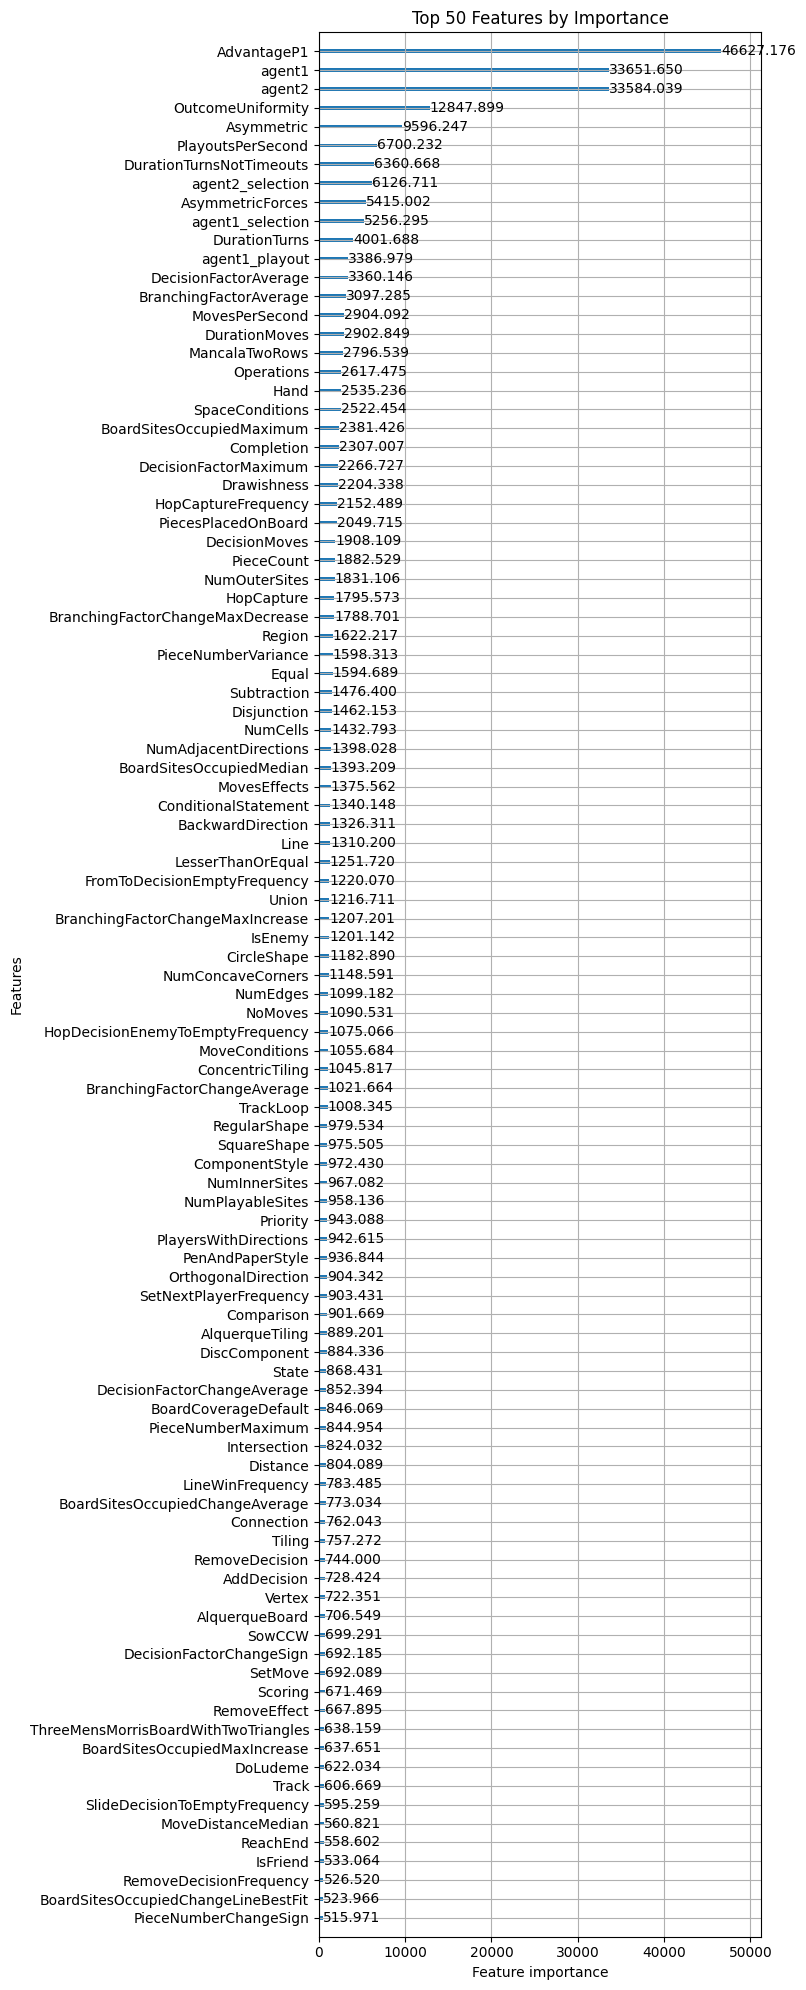

Fold 4 - RMSE: 0.43787791298161494
Fold 5


[50]	valid_0's rmse: 0.443487


[100]	valid_0's rmse: 0.427343


[150]	valid_0's rmse: 0.417879


[200]	valid_0's rmse: 0.412059


[250]	valid_0's rmse: 0.406345


[300]	valid_0's rmse: 0.404116


[350]	valid_0's rmse: 0.402091


[400]	valid_0's rmse: 0.400798


[450]	valid_0's rmse: 0.399445


[500]	valid_0's rmse: 0.39808


[550]	valid_0's rmse: 0.397293


[600]	valid_0's rmse: 0.396861


[650]	valid_0's rmse: 0.396664


[700]	valid_0's rmse: 0.396362


[750]	valid_0's rmse: 0.395753


[800]	valid_0's rmse: 0.395199


[850]	valid_0's rmse: 0.39481


[900]	valid_0's rmse: 0.394247


[950]	valid_0's rmse: 0.393863


[1000]	valid_0's rmse: 0.393382


[1050]	valid_0's rmse: 0.393178


[1100]	valid_0's rmse: 0.392871


[1150]	valid_0's rmse: 0.392659


[1200]	valid_0's rmse: 0.392675


[1250]	valid_0's rmse: 0.392444


[1300]	valid_0's rmse: 0.392159


[1350]	valid_0's rmse: 0.392035


[1400]	valid_0's rmse: 0.391744


[1450]	valid_0's rmse: 0.391523


[1500]	valid_0's rmse: 0.391439


[1550]	valid_0's rmse: 0.391343


[1600]	valid_0's rmse: 0.391235


[1650]	valid_0's rmse: 0.391191


[1700]	valid_0's rmse: 0.391114


[1750]	valid_0's rmse: 0.39102


[1800]	valid_0's rmse: 0.390932


[1850]	valid_0's rmse: 0.390972


[1900]	valid_0's rmse: 0.391058


[1950]	valid_0's rmse: 0.391035


[2000]	valid_0's rmse: 0.390857


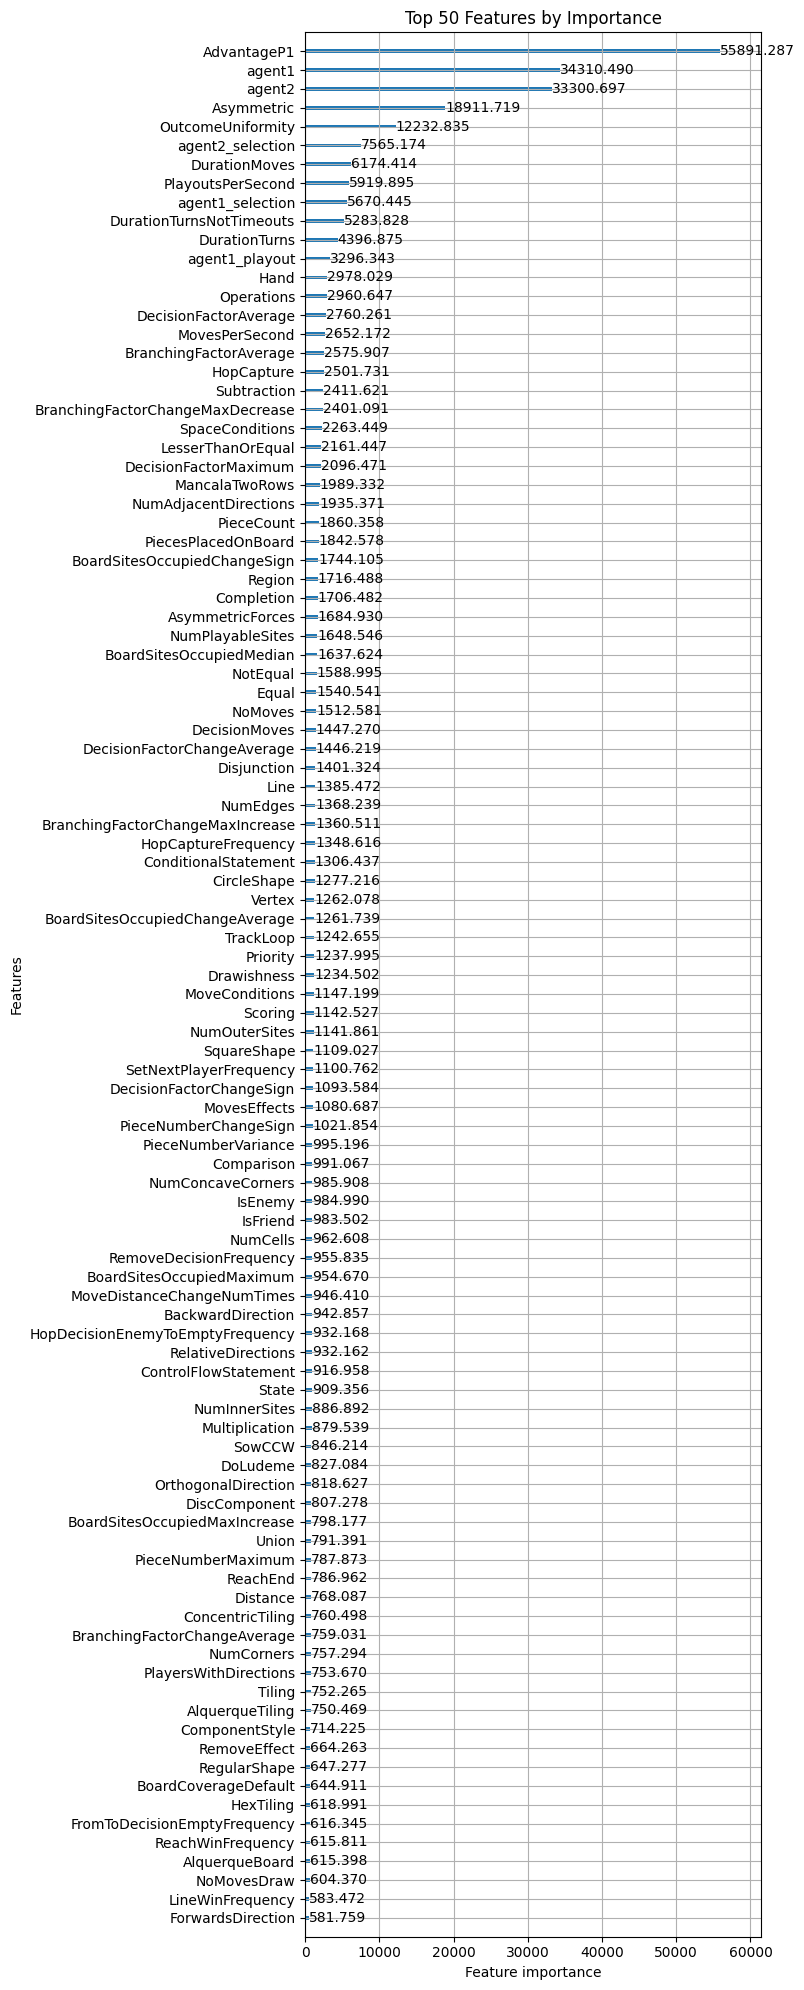

Fold 5 - RMSE: 0.38976851555086944
List of oof scores: [0.4545684219948849, 0.48150048506810533, 0.43102493775591777, 0.43787791298161494, 0.38976851555086944]
Average oof score: 0.43894805467027853


In [10]:
# call the function
trained_models3, oof3, oof_scores3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    num_folds=5,
    cv_random_state=23,
)
# save oof predictions
oof3.to_csv(path_results / 'oof_lightgbm_cv3.csv', index=False)

In [11]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]

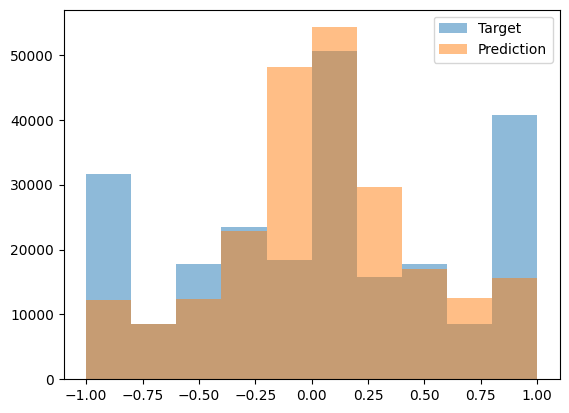

In [12]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [13]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [14]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [15]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.076244       │
│ 233235 ┆ -0.174424      │
│ 233236 ┆ -0.088535      │
└────────┴────────────────┘

In [16]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [17]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open('./lightgbm_predict.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***